# **Algorithmic Methods for Data Mining: Homework 4**

**Author:** Roberto Magno Mazzotta , Gabriel Pinos , Ata Berk Firat  <br>
*MSc. in Data Science, Sapienza University of Rome*



# <h1> Movie Recommendation System <img src="https://www.pngall.com/wp-content/uploads/13/Movie-Hollywood-No-Background.png" width=200 style="vertical-align: middle"> </h1> 

## **Introduction**
Our team has been tasked with designing a state of the art recommendation system that leverages advanced data analysis techniques to enhance user engagement. <br> The project focuses on two critical areas: hashing techniques to optimize data retrieval speed and clustering algorithms to group users based on shared movie preferences. 
<br>By combining these approaches, we aim to deliver faster, more accurate, and highly personalized movie recommendations that align with individual tastes and behaviors. <br>Tis project not only addresses the technical challenges of scalability and precision in recommendation systems but also paves the way for deeper insights into user behavior, enabling a more immersive and satisfying entertainment experience.


## **0. Uploading the Classes and Modules** <h3>  <img src="https://preview.redd.it/snoovatar/avatars/nftv2_bmZ0X2VpcDE1NToxMzdfZWI5NTlhNzE1ZGZmZmU2ZjgyZjQ2MDU1MzM5ODJjNDg1OWNiMTRmZV8yMTQ1NzYzNg_rare_46f1cdb1-634f-4c1d-8344-2be06c7880d4-headshot.png?width=256&height=256&crop=smart&auto=webp&s=400ead9440c7a9f06ca4c44953f24c5b765c4aac" width=150 style="vertical-align: middle"> </h3>

Before doing any kind of analysis it is necessary to upload both the relevant Classes and Modules we will use to work.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to datasets
path = "/Users/roberto/Desktop/HM4-ADM/datasets"
tag_df = pd.read_csv(f"{path}/tag.csv")
rating_df = pd.read_csv(f"{path}/rating.csv")
movie_df = pd.read_csv(f"{path}/movie.csv")
link_df = pd.read_csv(f"{path}/link.csv")
genome_scores_df = pd.read_csv(f"{path}/genome_scores.csv")
genome_tags_df = pd.read_csv(f"{path}/genome_tags.csv")

In [20]:
# !pip install pandas numpy tqdm seaborn
import pandas as pd
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns



## **1. Recommendation System with LSH**

In this homework, we were asked to implement our version of the [LSH algorithm](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/), which will take as input a user's preferred genre of movies, find the most similar users to this user, and recommend the most watched movies by those who are more similar to the user.

### **1.1. The Dataset**

We were provided with a [dataset](https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset?select=rating.csv) that describe ratings and free-text tagging activities from MovieLens, a movie recommendation service. 

It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.


The data are contained in six files.


- **tag.csv**: contains tags applied to movies by users:
    >- userId
    >- movieId
    >- tag
    >- timestamp

- **rating.csv**: contains ratings of movies by users:
    >- userId
    >- movieId
    >- rating
    >- timestamp

- **movie.csv**: contains movie information:
    >- movieId
    >- title
    >- genres

- **link.csv**: contains identifiers that can be used to link to other sources:
    >- movieId
    >- imdbId
    >- tmbdId

- **genome_scores.csv**: contains movie-tag relevance data:
    >- movieId
    >- tagId
    >- relevance
- **genome_tags.csv**: contains tag descriptions:
    >- tagId
    >- tag



In [21]:
# Inspect datasets
display("Tags Dataset:\n", tag_df.head())
display("Ratings Dataset:\n", rating_df.head())
display("Movies Dataset:\n", movie_df.head())
display("Links Dataset:\n", link_df.head())
display("Genome Scores Dataset:\n", genome_scores_df.head())
display("Genome Tags Dataset:\n", genome_tags_df.head())

'Tags Dataset:\n'

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


'Ratings Dataset:\n'

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


'Movies Dataset:\n'

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


'Links Dataset:\n'

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


'Genome Scores Dataset:\n'

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


'Genome Tags Dataset:\n'

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


# Focus on rating.csv ::


In [22]:
display(rating_df.head())

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [23]:
# Show the Rating Dataset informations
rating_df.info,rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


(<bound method DataFrame.info of           userId  movieId  rating            timestamp
 0              1        2     3.5  2005-04-02 23:53:47
 1              1       29     3.5  2005-04-02 23:31:16
 2              1       32     3.5  2005-04-02 23:33:39
 3              1       47     3.5  2005-04-02 23:32:07
 4              1       50     3.5  2005-04-02 23:29:40
 ...          ...      ...     ...                  ...
 20000258  138493    68954     4.5  2009-11-13 15:42:00
 20000259  138493    69526     4.5  2009-12-03 18:31:48
 20000260  138493    69644     3.0  2009-12-07 18:10:57
 20000261  138493    70286     5.0  2009-11-13 15:42:24
 20000262  138493    71619     2.5  2009-10-17 20:25:36
 
 [20000263 rows x 4 columns]>,
 None)

In [24]:
print(movie_df.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [25]:
# Define a function to obtain the film title without date
def splitter_title(text):
    text=text.split("(")
    return text[0]

In [26]:
# Apply the splitter_title function to the "title" column and store the result in "title2"
movie_df["title2"] = movie_df["title"].apply(splitter_title)

# Split the "genres" column by "|" and store the resulting list in "genre_list"
movie_df["genre_list"] = movie_df["genres"].str.split("|")

# Display the first 5 rows of the DataFrame to check the new columns
movie_df.head()

,movieId,title,genres,title2,genre_list
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,[Comedy]


### Why we use `map` instead of `merge`?

In this context, `map` is used because it is computationally more efficient for simple one-to-one mappings compared to `merge`. Here's why:

1. **Performance**:  
   `map` is faster when you need to map a single column based on a key-value relationship, as it avoids the overhead of merging entire DataFrames.

2. **Memory Usage**:  
   `map` consumes less RAM memory since it only operates on the relevant column and does not create a new DataFrame, unlike `merge`.



In [27]:
# Map 'title2' column to 'Movie Title'
rating_df["Movie Title"] = rating_df['movieId'].map(movie_df.set_index('movieId')['title2'])

# Map 'genre_list' column to 'Genre'
rating_df["Genre"] = rating_df['movieId'].map(movie_df.set_index('movieId')['genre_list'])

In [28]:
rating_df.head()

,userId,movieId,rating,timestamp,Movie Title,Genre
0,1,2,3.5,2005-04-02 23:53:47,Jumanji,"[Adventure, Children, Fantasy]"
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The","[Adventure, Drama, Fantasy, Mystery, Sci-Fi]"
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys,"[Mystery, Sci-Fi, Thriller]"
3,1,47,3.5,2005-04-02 23:32:07,Seven,"[Mystery, Thriller]"
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The","[Crime, Mystery, Thriller]"


In [29]:
# Show the new Rating Dataset informations
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   userId       int64  
 1   movieId      int64  
 2   rating       float64
 3   timestamp    object 
 4   Movie Title  object 
 5   Genre        object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB


In [30]:
# Check if there are NA values in the dataset
rating_df.isnull().sum()

userId         0
movieId        0
rating         0
timestamp      0
Movie Title    0
Genre          0
dtype: int64

### Information about the dataset

#### 1. **Time range and the number of movies released for each year**

In [31]:
# Convert the "timestamp" column to datetime format
rating_df["timestamp"] = pd.to_datetime(rating_df["timestamp"])

# Calculate the time range in years and print it with better formatting
time_range_years = rating_df["timestamp"].max().year - rating_df["timestamp"].min().year
print(f"The dataset covers a time range of {time_range_years} years, from {rating_df['timestamp'].min().year} to {rating_df['timestamp'].max().year}")

The dataset covers a time range of 20 years, from 1995 to 2015


In [32]:
# Define a new column with only year of timestamp column
rating_df['year'] = rating_df['timestamp'].dt.year

# Count unique movies per year
movies_per_year = rating_df.drop_duplicates(subset='Movie Title')['year'].value_counts().sort_index()

# Show the results
print(movies_per_year)

year
1996     331
1997     143
1998      99
1999     773
2000     485
2001     666
2002    1026
2003     548
2004     495
2005    1121
2006     512
2007    1267
2008     774
2009    1516
2010    1844
2011    2219
2012    2324
2013    2495
2014    3720
2015    2963
Name: count, dtype: int64


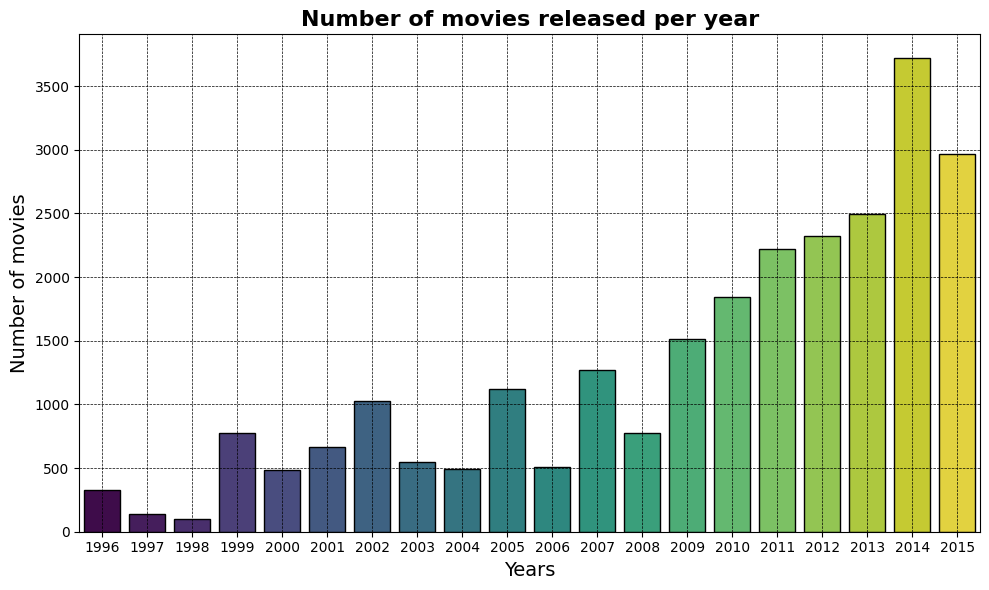

In [33]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=movies_per_year.index, 
    y=movies_per_year.values, 
    hue=movies_per_year.index,  # Assign 'x' to 'hue'
    palette='viridis', 
    edgecolor="black",
    dodge=False,  # Ensures bars are not split into groups
    legend=False  # Removes the legend for the hues
)
plt.title('Number of movies released per year', fontsize=16, fontweight='bold')
plt.xlabel('Years', fontsize=14)
plt.ylabel('Number of movies', fontsize=14)
plt.grid(linestyle='--', linewidth=0.5, color="black")
plt.tight_layout()
plt.show()

*The graph shows a clear upward trend in the number of movies released per year, with a significant spike in 2014 reaching over 3,000 movies. The data suggests that the movie industry has experienced substantial growth and expansion over the past two decades, with an increasing number of films being produced and released annually.*

#### 2. **Number of reviews per user**

In [34]:
# Group by 'userId', count the number of ratings each user has, and sort in descending order
user_rating_counts = rating_df.groupby('userId')['rating'].apply(len).sort_values(ascending=False)

# Print the results with clear labels
print(f"Top 5 users with the most ratings:\n{user_rating_counts.head(5)}")
print(f"\nBottom 5 users with the fewest ratings:\n{user_rating_counts.tail(5)}")

Top 5 users with the most ratings:
userId
118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
Name: rating, dtype: int64

Bottom 5 users with the fewest ratings:
userId
89305     20
110463    20
96990     20
134747    20
6526      20
Name: rating, dtype: int64


There are users who have watched more than 5000 different movies. Probably those who have watched so many movies are usually film critics, journalists or extremely dedicated film enthusiasts.

## *Final check for preprocessing*

In [58]:
import pandas as pd

# Preprocess Tags
tag_df['tag'] = tag_df['tag'].fillna('No Tag')  # Fill missing tags
tag_df['timestamp'] = pd.to_datetime(tag_df['timestamp'])  # Convert timestamp to datetime

# Preprocess Ratings
rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'])  # Convert timestamp to datetime

# Preprocess Movies
movie_df['genres'] = movie_df['genres'].fillna('Unknown')  # Fill missing genres
movie_df['year'] = movie_df['title'].str.extract(r'\((\d{4})\)').astype(float)  # Extract year
movie_df['genres'] = movie_df['genres'].str.split('|')  # Split genres into lists

# Preprocess Links
link_df = link_df.fillna(0)  # Fill missing external IDs

# Preprocess Genome Scores
genome_scores_df = genome_scores_df.fillna(0)  # Fill missing values

# Preprocess Genome Tags
genome_tags_df['tag'] = genome_tags_df['tag'].fillna('No Tag')  # Fill missing tags

# 1.2.0 Minhash Signatures

This function will **hash** each user's watched movie list to create a **signature vector**, which provides a compact representation of the user's preferences. By using **MinHash**, we can generate these signature vectors based on the movies that each user has rated. The key advantage of using MinHash is that it allows for **quick comparisons** of user similarity without directly comparing their entire lists of movies.

### Steps:
1. **Hash User's Movie List**: For each user, we generate a hash based on their watched movies.
2. **MinHash Signatures**: The MinHash function creates a **signature vector** for each user, which is a compressed version of their movie list.
3. **Efficient Similarity Comparison**: These signature vectors make it faster to compare users, enabling quick identification of similar users based on their movie preferences.


In [36]:
# Group the 'rating' DataFrame by 'userId', then apply 'set()' to the 'movieId' for each user.
user_movies=rating_df.groupby('userId')['movieId'].apply(set).to_dict()
print("User Movies:")
for user, movies in list(user_movies.items())[:5]:  # Display the first 5 users
    print(f"User {user}: {movies}")

User Movies:
User 1: {2, 3081, 4105, 1036, 5146, 541, 29, 32, 4128, 4133, 47, 1584, 5679, 50, 5171, 2100, 1079, 1080, 1089, 1090, 2628, 2118, 1097, 589, 7757, 7247, 593, 3153, 2644, 2648, 2138, 2140, 2143, 6242, 6754, 6755, 2664, 112, 1136, 4720, 6774, 2683, 2173, 2174, 4226, 2692, 653, 2193, 2194, 4754, 151, 6807, 2716, 5797, 1193, 1196, 1198, 1200, 1201, 6834, 8368, 1208, 5816, 6333, 1214, 1215, 1217, 3265, 1219, 1222, 2761, 2762, 2253, 4306, 1750, 1240, 1243, 7387, 7389, 1246, 223, 1249, 6888, 1258, 1259, 1261, 1262, 2288, 1266, 2291, 2804, 253, 1278, 8961, 260, 5898, 1291, 4878, 7438, 1304, 7449, 7454, 4896, 8482, 293, 296, 1321, 4911, 3889, 4915, 1333, 1848, 2872, 7482, 8507, 318, 5952, 1348, 1350, 4941, 1358, 337, 7001, 1370, 3932, 1374, 4446, 2918, 6502, 1387, 3438, 367, 5999, 4467, 4980, 1920, 2944, 4993, 2947, 7045, 7046, 6539, 2959, 3476, 919, 2968, 3479, 924, 3996, 3997, 3489, 5026, 5540, 3499, 4011, 1967, 5039, 5040, 3000, 4027, 8636, 1994, 1997, 6093, 31696, 3030, 4571, 30

MinHash is a technique used for approximating the similarity between sets, such as the set of movies each user has watched in a recommendation system. It uses multiple hash functions to generate **signature vectors** that represent the set of movies a user has rated.

For the MinHash we defined three different type of Hash function. In details:

# **1.2.1 The three Hash Functions:**

### 1. **Linear Hash Function**
The **linear** hash function is the simplest type, using the formula:

$ Hash(x) = (a \cdot x + b) \mod p $

Where:
- **a** and **b** are random coefficients ;
- **p** is a prime number (for example 10513) ;
- **x** is the movie ID.

The idea behind this hash function is to perform a linear transformation of the movie ID, and then take the result modulo p. This produces a unique integer for each movie, which is used to create the signature.

---

### 2. **Polynomial Hash Function**
The **polynomial** hash function works similarly to the linear function, but instead of a simple linear transformation, it applies polynomial powers to the movie ID. The formula is:

$ Hash(x) =  \sum_{i=0}^{n} c_i \cdot (x^i) \mod p $

Where:
- $\mathbf{c_{i}}$ are random coefficients for each power of x ;
- **p** is a prime number (for example 10513) ;
- **n** is the degree of the polynomial ;
- **x** is the movie ID.

In this case, the movie ID is raised to successive powers, with each term multiplied by a corresponding random coefficient. The sum is then taken modulo **p**.

---

### 3. **Universal Hash Function**
The **universal** hash function is a more advanced form of hashing that uses `double hashing` to reduce the probability of collisions in a hash table. The idea is to apply two hash functions and combine the results to get a more uniform distribution of hashes.
The second hash function applies an additional step using the value obtained from the first function ($ Hash_1(x) $ ) and a larger modulus m.

$ Hash_1(x) $ = $ ((a \cdot x + b) \mod p) $  

$ Hash_2(x) $ = $ ((a \cdot Hash_1(x) + b) \mod m) $  

$ Hash_{1,2}(x)=(Hash_1(x)+Hash_2(x)) \mod m $

Where:
- **a** and **b** are random coefficients ;
- **p** is a prime number (for example 10513) ;
- **m** is the modulus used to limit the hash output to a specific range. It is generally a prime number larger than the modulus used in the first hash function to reduce the risk of collisions.

### MinHash Process:

1. **Random Coefficients** : For each hash function, random values a and b are generated within the range of the modulus p ;
   
2. **Hashing Process** : For each movie in the user's watched list, apply the formula \hash(x) for each hash function. This results in a unique integer value (hash) for each movie ;

3. **Signature Vector** : The minimum hash value for each of the hash functions is selected from the set of movie hashes. This set of minimum values across all hash functions forms the **signature vector** for the user.


In [37]:
from libs.minhash_similarity import MinHash

# Show the informations about the two functions of the MinHash module:
help(MinHash)

Help on class MinHash in module libs.minhash_similarity:

class MinHash(builtins.object)
 |  MinHash(n_hash_functions: int = 100, prime_number: int = 10513, type_function: str = 'linear')
 |  
 |  Methods defined here:
 |  
 |  __init__(self, n_hash_functions: int = 100, prime_number: int = 10513, type_function: str = 'linear')
 |      Initialize MinHash with a specified number of hash functions.
 |      
 |      Args:
 |          n_hash_functions: Number of hash functions to use for creating signatures (default is 100)
 |          prime: A higher prime number for the hash function (default is 10513)
 |          type_function: Type of hash function to use ('linear', 'universal', 'polynomial')
 |  
 |  create_signature(self, movie_set)
 |      Create MinHash signature for a set of movies.
 |      
 |      Args:
 |          movie_set: Set of movie IDs
 |          
 |      Returns:
 |          np.ndarray: MinHash signature (array of minimum hash values)
 |  
 |  hash_function(self, x, a, 

### **1.2 Minhash Signatures Jaccard Similarity**

As a next step, we were asked to use the **userId** and **movieId**  column to try to implement min-hash signatures in order that users with similar interests in a genre appear in the same bucket. To do this we used the custom-made `minHash` class we built specifically for this homework. For more information on the **implementation** of the code behind it, please refer to the `lsh_functions` file included in the `libs` folder of this repository.

We can initialize our class:

In [ ]:
from libs.minhash_similarity import generate_signatures, exact_jaccard_similarity, compute_similarities

In [39]:
# check in libs.minhash_similarity -> generate signatures to check the function made from scrath 
help(generate_signatures)

Help on function generate_signatures in module libs.minhash_similarity:

generate_signatures(user_movies: dict, num_hash_function: int, function_name: str)



## **Jaccard Similarity** 
#### *(or Jaccard Index)*
##### *Is a statistical measure used to compare the similarity and diversity between two sets. It is commonly used to calculate the similarity between two sets of items, such as the sets of movies watched by two users in a recommendation system.*

#### Formula:

The formula to calculate Jaccard Similarity between two sets A and B is as follows:

$$\ J(A, B) = \frac{|A \cap B|}{|A \cup B|}\$$

Where:
- \|A $\cap B|$ is the **cardinality of the intersection** of A and B , the number of elements common to both sets.
- \|A $\cup B|$ is the **cardinality of the union** of  A and B , the total number of elements present in at least one of the two sets.


In [40]:
# check in libs.minhash_similarity ->  exact_jaccard_similarity to check the function made from scrath 
help(exact_jaccard_similarity)

Help on function exact_jaccard_similarity in module libs.minhash_similarity:

exact_jaccard_similarity(sig1, sig2)
    sig1 : the signature of the user 1
    sig2 : the signature of the user 2



### `compute_similarities` function

This function calculates Jaccard similarity between randomly sampled user pairs (1000 samples) to reduce computation time. Instead of comparing all users, it randomly selects a subset for similarity calculation using MinHash. 

Pairs with estimated Jaccard similarity above a given threshold (0.6) are considered similar.

- **Random Sampling:** 1000 random user pairs are selected ;
- **Thresholding:** Pairs with estimated similarity above the threshold are counted as similar ;
- **Outputs:** The function prints the most similar pairs, average loss and the count of similar/non-similar user pairs.

**Considerations**

We chose this sample size to evaluate whether the Jaccard similarities estimated by the algorithm align with the real Jaccard similarities of the users. Conducting a complete analysis involving all users would have required nearly 10 billion comparisons, making it hard computationally.


In [41]:
help(compute_similarities)

Help on function compute_similarities in module libs.minhash_similarity:

compute_similarities(user_signatures, user_movies, max_results=10, similarity_threshold=0.6, hash_functions=100)



In [42]:
# Print and generate signatures with different types of hash functions and 50 hash functions

# Using Linear hash functions

print("Generating signatures with Linear hash function --> 50 hash functions:")
signatures_linear_50 = generate_signatures(user_movies, 50 , function_name='linear')
print("-" * 80)

# Using Universal hash functions

print("Generating signatures with Universal hash function --> 50 hash functions:")
signatures_universal_50 = generate_signatures(user_movies, 50 , function_name='universal')
print("-" * 80)

# Using Polynomial hash functions

print("Generating signatures with Polynomial hash function --> 50 hash functions:")
signatures_polynomial_50 = generate_signatures(user_movies, 50 , function_name='polynomial')

Generating signatures with Linear hash function --> 50 hash functions:


Generating Signatures: 100%|██████████| 138493/138493 [05:01<00:00, 459.66it/s]


--------------------------------------------------------------------------------
Generating signatures with Universal hash function --> 50 hash functions:


Generating Signatures: 100%|██████████| 138493/138493 [06:41<00:00, 344.79it/s]


--------------------------------------------------------------------------------
Generating signatures with Polynomial hash function --> 50 hash functions:


Generating Signatures: 100%|██████████| 138493/138493 [11:44<00:00, 196.57it/s]


<h4> Now we compute the similarities for the three Hash Functions using the previously defined function for each set of signatures with a different number of hash functions </h4>
 

In [43]:
# 1. Linear
print("Similarities with Linear Hash Function --> 50 Hash Functions:")
print(compute_similarities(signatures_linear_50, user_movies, hash_functions=50))

Similarities with Linear Hash Function --> 50 Hash Functions:
Users: (26219, 35593) --> Estimated: 0.88, Exact: 0.84, Loss: 0.04
Users: (18916, 41335) --> Estimated: 0.80, Exact: 0.82, Loss: 0.02
Users: (2028, 41335) --> Estimated: 0.78, Exact: 0.83, Loss: 0.05
Users: (92201, 17104) --> Estimated: 0.78, Exact: 0.67, Loss: 0.11
Users: (42267, 64287) --> Estimated: 0.72, Exact: 0.72, Loss: 0.00
Users: (132685, 26219) --> Estimated: 0.72, Exact: 0.71, Loss: 0.01
Users: (91064, 50559) --> Estimated: 0.70, Exact: 0.66, Loss: 0.04
Users: (106591, 10123) --> Estimated: 0.70, Exact: 0.64, Loss: 0.06
Users: (92201, 19488) --> Estimated: 0.70, Exact: 0.62, Loss: 0.08
Users: (132685, 35593) --> Estimated: 0.68, Exact: 0.69, Loss: 0.01

Average Loss: 0.0407

Number of similar user pairs (estimated similarity > 0.6): 28, Number of non similar user pairs is 972
None


In [44]:
# 2. Universal
print("Similarities with Universal Hash Function --> 50 Hash Functions:")
print(compute_similarities(signatures_universal_50, user_movies, hash_functions=50))

Similarities with Universal Hash Function --> 50 Hash Functions:
Users: (2028, 41335) --> Estimated: 0.90, Exact: 0.83, Loss: 0.07
Users: (26219, 35593) --> Estimated: 0.90, Exact: 0.84, Loss: 0.06
Users: (18916, 41335) --> Estimated: 0.86, Exact: 0.82, Loss: 0.04
Users: (2028, 18916) --> Estimated: 0.76, Exact: 0.68, Loss: 0.08
Users: (132685, 26219) --> Estimated: 0.76, Exact: 0.71, Loss: 0.05
Users: (42267, 64287) --> Estimated: 0.74, Exact: 0.72, Loss: 0.02
Users: (84791, 74344) --> Estimated: 0.74, Exact: 0.54, Loss: 0.20
Users: (41335, 97084) --> Estimated: 0.72, Exact: 0.68, Loss: 0.04
Users: (41335, 35593) --> Estimated: 0.72, Exact: 0.69, Loss: 0.03
Users: (25173, 35593) --> Estimated: 0.72, Exact: 0.69, Loss: 0.03

Average Loss: 0.0594

Number of similar user pairs (estimated similarity > 0.6): 52, Number of non similar user pairs is 948
None


In [45]:
# 3. Polynomial 
print("Similarities with Polynomial Hash Function --> 50 Hash Functions:")
print(compute_similarities(signatures_polynomial_50, user_movies, hash_functions=50))

Similarities with Polynomial Hash Function --> 50 Hash Functions:
Users: (18916, 41335) --> Estimated: 0.88, Exact: 0.82, Loss: 0.06
Users: (26219, 35593) --> Estimated: 0.86, Exact: 0.84, Loss: 0.02
Users: (2028, 41335) --> Estimated: 0.82, Exact: 0.83, Loss: 0.01
Users: (91064, 50559) --> Estimated: 0.80, Exact: 0.66, Loss: 0.14
Users: (41335, 35593) --> Estimated: 0.76, Exact: 0.69, Loss: 0.07
Users: (15938, 35593) --> Estimated: 0.76, Exact: 0.71, Loss: 0.05
Users: (90345, 17104) --> Estimated: 0.74, Exact: 0.64, Loss: 0.10
Users: (25173, 35593) --> Estimated: 0.74, Exact: 0.69, Loss: 0.05
Users: (64287, 50559) --> Estimated: 0.72, Exact: 0.59, Loss: 0.13
Users: (2028, 18916) --> Estimated: 0.70, Exact: 0.68, Loss: 0.02

Average Loss: 0.0610

Number of similar user pairs (estimated similarity > 0.6): 44, Number of non similar user pairs is 956
None


# MinHash Similarity Comparison

---

### 1. **Linear Hash Function (50 Hash Functions)**
   - The Linear Hash Function demonstrates the **lowest average loss** among the three. This indicates that its similarity estimates are consistently close to the true values. 
   - Given its balance between precision and computational efficiency, it is the **best choice** for  applications requiring a good trade-off between accuracy and processing time.

---

### 2. **Universal Hash Function (50 Hash Functions)**
   - The universal hash function has a **computational complexity similar to the linear**. In the tests conducted, **the average loss is unstable**, in most cases it was the slightly higher one among the other functions with a loss of 0.1 although it can also reach a lower loss.
---

### 3. **Polynomial Hash Function (50 Hash Functions)**
   - The polynomial hash function shows a **relatively low average loss**, but it is the **most computationally expensive** among the three. It is a good alternative when higher precision is needed, but with a higher computational cost respect linear.
---

### **Conclusion**
   - The Linear Hash Function is the best choice, with the lowest average loss and good computational performance.


<h3> To further improve the similarity and reduce the average loss, we increase the number of Hash functions for the linear. </h3>

In details:
- We define signatures for each user id with a higher number of Hash functions (100,200). We expect that higher number of functions will lead to higher computational cost but very high accuracy ;
- We calculate the estimated Jaccard with 100,200 Hash functions and observe the differences from the exact Jaccard between different users ;
- Let's compare the results by looking at the average loss calculated on a random sample of 1000 users as a metric ;

<h3> Compare similarity for 100-200 number of Hash Functions </h3>

In [46]:
# Let's try with 100 and 200 functions to see if the avg loss will be lower

# The length of the signature increases further, improving the similarity
signatures_linear_100 = generate_signatures(user_movies, 100,function_name='linear')

print("-" * 80)

# Much more detailed signature, suitable for the scenario where high precision is needed
# It is the most expensive in terms of memory and computation.
signatures_linear_200 = generate_signatures(user_movies, 200,function_name='linear')

Generating Signatures: 100%|██████████| 138493/138493 [10:01<00:00, 230.11it/s]


--------------------------------------------------------------------------------


Generating Signatures: 100%|██████████| 138493/138493 [20:36<00:00, 112.01it/s]


In [47]:
print("Similarities with 100 Hash Functions:")
print(compute_similarities(signatures_linear_100,user_movies,hash_functions=100))

print("-" * 80)

print("Similarities with 200 Hash Functions:")
print(compute_similarities(signatures_linear_200,user_movies,hash_functions=200))

Similarities with 100 Hash Functions:
Users: (26219, 35593) --> Estimated: 0.85, Exact: 0.84, Loss: 0.01
Users: (2028, 41335) --> Estimated: 0.83, Exact: 0.83, Loss: 0.00
Users: (18916, 41335) --> Estimated: 0.79, Exact: 0.82, Loss: 0.03
Users: (91064, 50559) --> Estimated: 0.75, Exact: 0.66, Loss: 0.09
Users: (64287, 118850) --> Estimated: 0.73, Exact: 0.64, Loss: 0.09
Users: (93094, 50559) --> Estimated: 0.71, Exact: 0.68, Loss: 0.03
Users: (132685, 26219) --> Estimated: 0.71, Exact: 0.71, Loss: 0.00
Users: (132685, 35593) --> Estimated: 0.71, Exact: 0.69, Loss: 0.02
Users: (106591, 33207) --> Estimated: 0.70, Exact: 0.63, Loss: 0.07
Users: (92201, 17104) --> Estimated: 0.70, Exact: 0.67, Loss: 0.03

Average Loss: 0.0391

Number of similar user pairs (estimated similarity > 0.6): 39, Number of non similar user pairs is 961
None
--------------------------------------------------------------------------------
Similarities with 200 Hash Functions:
Users: (26219, 35593) --> Estimated: 0.

## *1.2 bis : Second approach for MinHash function and analysis* 

# **Main Differences Between Two MinHash Implementations**

### **1. Hash Function Types**
- **First Implementation**:
  - Uses three different MinHash function types: `linear`, `polynomial`, and `universal`.
  - Focuses on experimenting with multiple hashing techniques and evaluating their effectiveness.

- **Second Implementation**:
  - Does not include multiple hash function types; instead, it uses hash functions to simulate row permutations for MinHashing.

---

### **2. Matrix Representation**
- **First Implementation**:
  - Operates directly on user-movie mappings without explicitly constructing a characteristic matrix.

- **Second Implementation**:
  - Explicitly builds and visualizes the **characteristic matrix** as a binary user-item interaction matrix.
  - Demonstrates how MinHash signatures are derived from this matrix.

---

### **3. Visualization**
- **First Implementation**:
  - Focuses on comparing MinHash function performances and similarity computation results.

- **Second Implementation**:
  - Visualizes the **characteristic matrix**, signature matrix, and the impact of hash functions on similarity.

---

### **Summary**
- The **first implementation** focuses on evaluating different MinHash functions and their efficiency, while the **second implementation** emphasizes the conceptual understanding of MinHashing through matrix construction and visualization.

In [59]:
# Import necessary functions , other custom made
from libs.lsh_functions import ( 
    create_characteristic_matrix, 
    generate_minhash_signatures, 
    compute_jaccard_similarity, 
    compute_similarities, 
    recommend_movies, 
    plot_probability_curve, 
    visualize_signature_matrix, 
    create_sparse_interaction_matrix, 
    generate_minhash_signatures_with_interaction, 
    create_sparse_interaction_matrix_from_binary
)

Now, in order to perform Minhashing, we must perform the following steps:

#### **1.2.1. Shingling**

In this case, we define each different **movieId** as a shingle and represent our users as sets of shingles. Shingles are essentially the unique identifiers (IDs) of the movies that a user has interacted with or rated.

For example, we can represent a user A as:

$$A = \{\text{movie1}, \text{movie2}, \text{movie2}, \dots\},$$

Where the set contains the movieId values corresponding to the movies that the user  A  has watched or rated.

This representation captures the set of movies associated with each user, which is the fundamental input for building the characteristic matrix and applying MinHashing.

We can extract the movie shingles for every user in our dataset. For example, user 1 can be represented by their movie shingles as follows:

In [60]:
user_movies = rating_df.groupby('userId')['movieId'].apply(list)
print(f"Movies watched by User 1: {user_movies[1]}")

Movies watched by User 1: [2, 29, 32, 47, 50, 112, 151, 223, 253, 260, 293, 296, 318, 337, 367, 541, 589, 593, 653, 919, 924, 1009, 1036, 1079, 1080, 1089, 1090, 1097, 1136, 1193, 1196, 1198, 1200, 1201, 1208, 1214, 1215, 1217, 1219, 1222, 1240, 1243, 1246, 1249, 1258, 1259, 1261, 1262, 1266, 1278, 1291, 1304, 1321, 1333, 1348, 1350, 1358, 1370, 1374, 1387, 1525, 1584, 1750, 1848, 1920, 1967, 1994, 1997, 2021, 2100, 2118, 2138, 2140, 2143, 2173, 2174, 2193, 2194, 2253, 2288, 2291, 2542, 2628, 2644, 2648, 2664, 2683, 2692, 2716, 2761, 2762, 2804, 2872, 2918, 2944, 2947, 2959, 2968, 3000, 3030, 3037, 3081, 3153, 3265, 3438, 3476, 3479, 3489, 3499, 3889, 3932, 3996, 3997, 4011, 4027, 4105, 4128, 4133, 4226, 4306, 4446, 4467, 4571, 4720, 4754, 4878, 4896, 4911, 4915, 4941, 4980, 4993, 5026, 5039, 5040, 5146, 5171, 5540, 5679, 5797, 5816, 5898, 5952, 5999, 6093, 6242, 6333, 6502, 6539, 6754, 6755, 6774, 6807, 6834, 6888, 7001, 7045, 7046, 7153, 7164, 7247, 7387, 7389, 7438, 7449, 7454, 7482

In [61]:
# Merge rating_df with movie_df to include movie titles
merged_df = pd.merge(rating_df, movie_df, on='movieId')

# Display the first few rows
merged_df.head()

,userId,movieId,rating,timestamp,title,genres,year
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),"[Adventure, Children, Fantasy]",1995.0
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...","[Adventure, Drama, Fantasy, Mystery, Sci-Fi]",1995.0
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"[Mystery, Sci-Fi, Thriller]",1995.0
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",1995.0
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",1995.0


Here we can see that the movies watched by each user (e.g., User `1`) are represented by their unique `movieId` values. This gives us insight into the specific movies a user has interacted with. We can do this for every user and represent each individual user by the set of `movieId`s they have rated or interacted with. However, to effectively compare users, we need to represent them in a way that accounts for all possible movies regardless of the order in which they appear.

###  **Building the Characteristic Matrix**

Once we've represented each of our users using their `movieId` shingles, we can construct the **characteristic matrix** for users. In this matrix:

- Each **column** corresponds to a unique user (`userId`).
- Each **row** corresponds to a unique movie (`movieId`) from the universal set of movies that appear in the dataset.

The value in the element  $(i, j)$  of the matrix is 1  if the movie in row $i$  has been rated or interacted with by the user in column $j$ ; otherwise, it is  0. The resulting matrix looks like this:

<br>

$$
\begin{pmatrix}
& \text{User ID 1}&\text{User ID 2}&\dots&\text{User $ID(n-1)$}&\text{User ID $n$}\\
\text{Movie ID 1} &1&0&\dots&0&1\\
\text{Movie ID 2} &0&0&\dots&1&0\\
\vdots &0&1&\dots&0&1\\
\text{Movie ID $m-1$} &1&0&\dots&1&1\\
\text{Movie ID $m$} &0&0&\dots&1&0
\end{pmatrix}
$$

<br>

For example, the first row represents **Movie 1**, and we can see that Users  1  and $n$  have interacted with this movie, while the others have not. Similarly, other rows correspond to different movies, and columns represent the one-hot encoded interaction of users with those movies.

We can think of this matrix as the **one-hot representation** of users based on the movies they have interacted with. This representation is critical for computing MinHash signatures.

For completeness, we can extract the column of this matrix for a specific user, such as User `1`, which gives the binary interaction vector of that user with the movies:


In [62]:
# Create a binary interaction matrix
interaction_matrix = pd.pivot_table(
    merged_df, 
    values='rating', 
    index='movieId', 
    columns='userId', 
    aggfunc=lambda x: 1,  # Use 1 to indicate interaction
    fill_value=0          # Fill with 0 for no interaction
)

interaction_matrix.head()

/var/folders/jp/fnr369_172b9ghtllhyqdmtw0000gp/T/ipykernel_45736/2151508797.py:2: PerformanceWarning: The following operation may generate 3703856792 cells in the resulting pandas object.
  interaction_matrix = pd.pivot_table(


userId,1,2,3,4,5,6,7,8,9,10,...,138484,138485,138486,138487,138488,138489,138490,138491,138492,138493
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,1,0,1,0,1,...,0,0,1,0,1,0,0,1,0,1
2,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
3,0,1,0,0,0,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


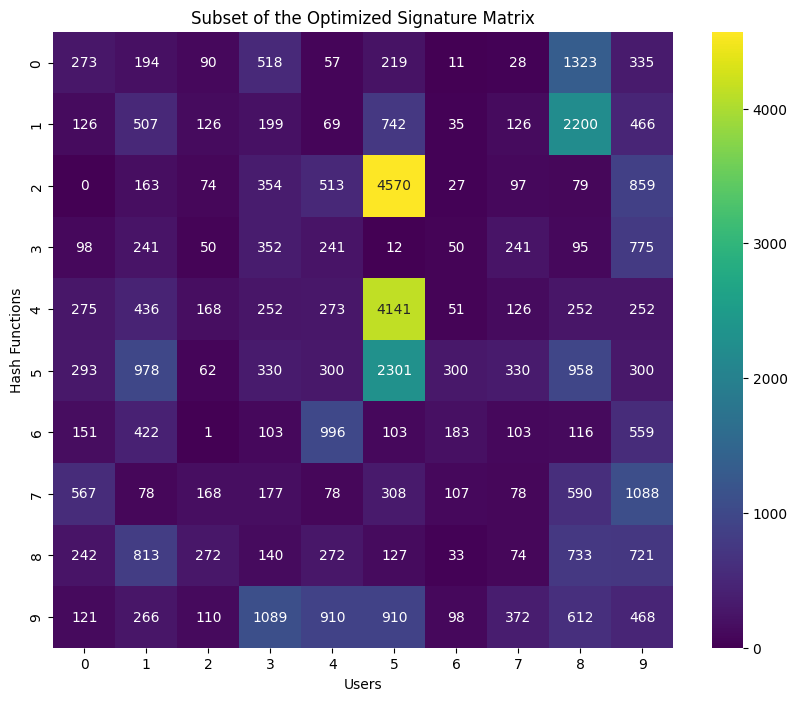

In [ ]:
from libs.lsh_functions import plot_signature_matrix, plot_hash_param_effects

# Visualize the first 10x10 portion of the signature matrix
plot_signature_matrix(signature_matrix, rows=10, cols=10)

# Analyze the effect of hash function parameters
#plot_hash_param_effects(n_hashes=100, movie_range=range(1, interaction_matrix.shape[0]))

As we can see, we only have 1 values in certain indexes representing the movies the user has rated. These correspond to the specific `movieId`s the user interacted with. Using this representation, we can compare users based on their rated movies. However, as the number of users and movies grows, this representation becomes inefficient due to the sparsity of the matrix. 

To address this issue, we replace the large characteristic matrix with a smaller **signature matrix** that still preserves the underlying similarity between users.

### **Min-Hashing**

We achieve this by building a **signature matrix** using **Min-Hashing**. To create this matrix from the characteristic matrix, we follow these steps:

1. **Randomly permute the rows** of the characteristic matrix. For example, rows `12345` might become `35421`, so if "Movie A" was in row 1, it would now be in row 5.

2. For each user (i.e., column), **find the position of the first non-zero value** (indicating a rated movie) in the permuted rows. This position is used to represent the user's interaction for that permutation.

3. **Repeat this process** as many times as desired, appending each result to the user's signature vector.

Instead of explicitly permuting the rows (which is computationally expensive), we use **hash functions** to simulate the permutation process. A hash function for an input integer $x$ is defined as:

$$
h(x) = (ax + b) \mod c
$$

where:
- $a$ and $b$ are random integers less than the number of rows of the matrix.
- $c$ is a **prime number** slightly larger than the number of rows.

This approach avoids true permutations and computes the hash values directly. While this may result in hash collisions (where two rows map to the same value), the effect can be minimized by choosing appropriate values for $a$, $b$, and $c$.

Using this framework, our algorithm proceeds as follows:

1. Initialize the **signature matrix** with all values set to $\infty$.

2. For each row, compute $h_1(r), h_2(r), \dots, h_n(r)$ for $n$ random hash functions.

3. For each column $c$ of row $r$:
    - If $c$ has a $0$ in row $r$, skip it.
    - If $c$ has a $1$ in row $r$, update $S(i, c)$ for each $i \in \{1, \dots, n\}$ to be the **minimum** of the current value of $S(i, c)$ and $h_i(r)$.

The resulting **signature matrix** has dimensions determined by the number of hash functions (or permutations) and the number of users.

For our Recommendation System, we chose **100 hash functions**, so the resulting signature matrix has dimensions:

'Shape of the signature matrix:'

(100, 5)

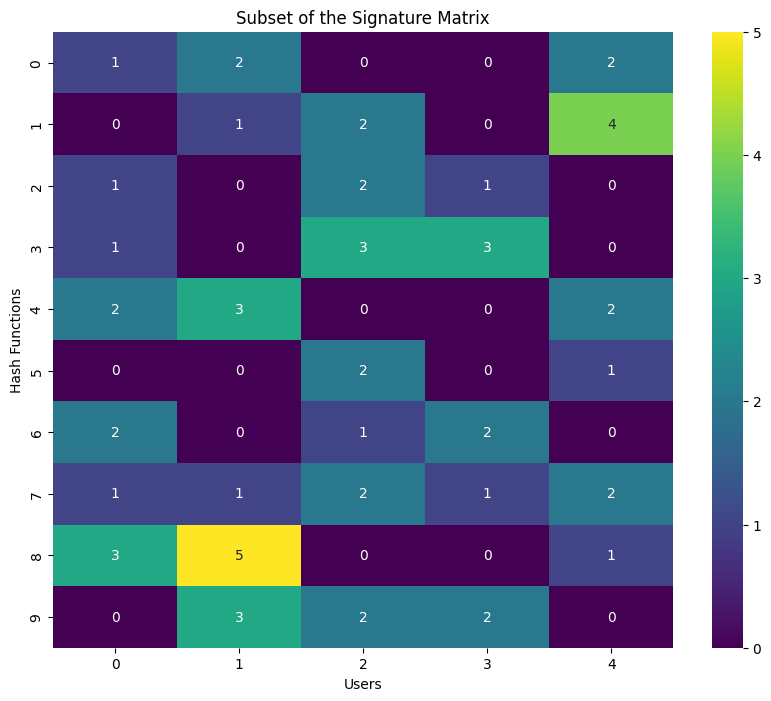

In [3]:
# Import the custom functions from your library
from libs.lsh_functions import create_characteristic_matrix, generate_minhash_signatures, next_prime, visualize_signature_matrix


# A dictionary where keys are user IDs and values are sets of movie IDs watched by the user
user_movies = {
    1: {1, 2, 3},
    2: {3, 4},
    3: {5, 6},
    4: {1, 3, 5},
    5: {2, 4, 6}
}

# All movies in the dataset
all_movies = {1, 2, 3, 4, 5, 6}

# Create the characteristic matrix
characteristic_matrix = create_characteristic_matrix(None, all_movies, user_movies)

# Generate MinHash signatures with a specified number of hash functions
n_hashes = 100
signature_matrix = generate_minhash_signatures(characteristic_matrix, n_hashes)

# Obtain the shape of the signature matrix
display("Shape of the signature matrix:", signature_matrix.shape)

# Visualize the first 10 rows and columns of the signature matrix using a heatmap
visualize_signature_matrix(signature_matrix, rows=10, cols=10)

---

Through this method, we produce vectors of equal length that contain positive integer values representing the MinHash signatures for each user, based on the movies they have rated. These signatures allow us to approximate user similarity efficiently. Ideally, we want to hash users into **buckets** such that users with similar preferences (based on their movie lists) end up in the same bucket. However, if we hash based on the entire signature as a whole, only identical signatures would end up in the same bucket, which is not practical for approximate similarity searches.

In most cases, even though parts of two signatures may match, they might still be hashed into separate buckets. This is undesirable because it prevents us from identifying partially similar users. To address this, we use the **banding** technique.

#### **Banding and Bucketing**

The banding method addresses this issue by splitting the MinHash signature matrix into smaller sub-vectors called *bands*. Instead of hashing the entire signature for a user into a single bucket, we hash each band independently. For instance, splitting a 100-dimensional signature into 20 bands results in 20 opportunities to match users based on their sub-vector similarity.

While this increases the chance of false positives (users hashed into the same bucket despite being dissimilar), we can tune the trade-off by adjusting the number of bands (\(b\)) and the number of rows per band \($r$\). The probability of a pair of users being hashed into the same bucket given their Jaccard similarity \($s$\) is:

$$
\mathbb{P} = 1 - (1 - s^r)^b,
$$

where:

- \($b$)\: Number of bands (splits in the signature matrix).
- \($r$)\: Number of rows per band:
$$r = \frac{\text{signature length}}{b}$$


The **Jaccard Similarity** between users refers to the similarity between the sets of movies they have rated. We can visualize the effect of different banding configurations by plotting this probability for varying values of \($b$\):

```python
# Plot the probability of users being hashed into the same bucket as a function of their similarity
plot_probability_curve(n=100, band_values=[5, 20, 25, 50]) 

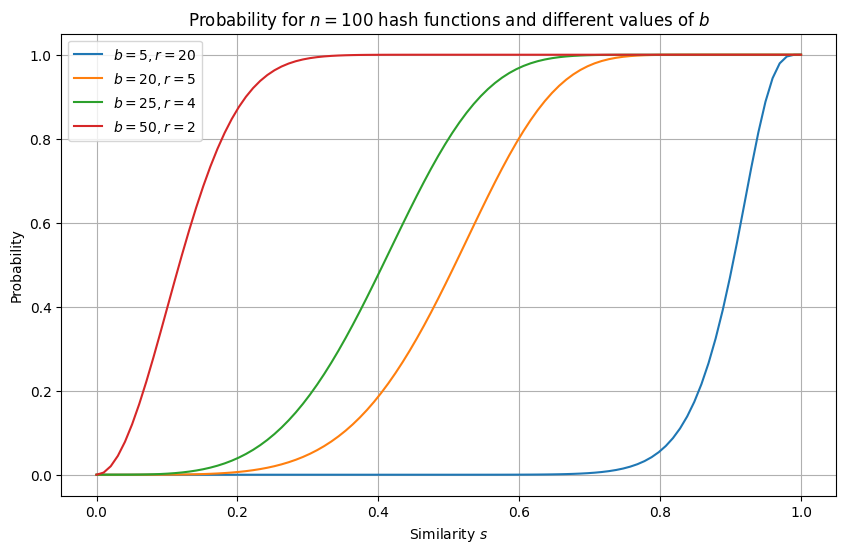

In [6]:
# Example: Plot the probability curve
plot_probability_curve(n=100, band_values=[5, 20, 25, 50])

### **Probability Plot for MinHash Banding**

This visualization shows the **probability of two users being hashed into the same bucket** as a function of their similarity $s$, based on different banding configurations in the MinHash algorithm.

#### **Key Aspects**

1. **Hash Functions ($n = 100$)**:
   - The total number of hash functions used to generate the MinHash signatures is fixed at $n = 100$.

2. **Banding Parameter ($b$)**:
   - The curves represent different values of $b$ (number of bands).
   - For example:
     - $b = 5$: Larger number of rows per band ($r = n / b = 20$).
     - $b = 50$: Smaller number of rows per band ($r = n / b = 2$).

3. **Trade-off Between $b$ and $r$**:
   - **Fewer bands ($b$) and more rows per band ($r$)**:
     - The curve is steeper, requiring higher similarity for users to be hashed to the same bucket.
     - Reduces false positives but increases false negatives.
   - **More bands ($b$) and fewer rows per band ($r$)**:
     - The curve is smoother, allowing even lower similarity pairs to hash into the same bucket.
     - Increases false positives but reduces false negatives.

4. **Interpretation of Similarity $s$**:
   - $s = 0$: Probability is $0$, meaning users with no similarity will not hash to the same bucket.
   - $s = 1$: Probability is $1$, meaning users with identical signatures will always hash to the same bucket.
   - Intermediate $s$ values (e.g., $s = 0.4, 0.6$): The probability increases as similarity grows, depending on $b$ and $r$.

5. **Use Case**:
   - This plot helps determine the optimal $b$ and $r$ configuration based on the desired trade-off between false positives and false negatives.

#### **Probability Formula**:
The probability of a pair of users being hashed into the same bucket is given by:
$$
\mathbb{P} = 1 - (1 - s^r)^b
$$
where:
- $b$: Number of bands.
- $r$: Number of rows per band $\left(r = \frac{\text{signature length}}{b}\right)$.

#### **Recommendation**
- For applications that require **high precision** (fewer false positives), choose configurations with fewer bands ($b = 5$ or $b = 10$).
- For applications that tolerate **false positives** but emphasize capturing similar users, choose configurations with more bands ($b = 25$ or $b = 50$).

---


# 1.3.0 Locality-Sensitive Hashing (LSH)

Our approach leverages Locality-Sensitive Hashing (LSH) with 200 hash functions to efficiently compute user similarities at scale. By generating compact signatures for each user, we dramatically reduce computational complexity from O(n²) to near-linear time.

Key implementation details:

1. 200 hash functions create robust user signatures
2. Low average loss ensures high-quality similarity detection

The LSH model transforms the Jaccard similarity computation among the 138,000 users of the dataset, reducing the complexity from O(n²) to O(num_bands $\cdot$ rows_per_band + k) where:
- **num_bands** is the number of bands the signature is divided into ;
- **rows_per_band** is the number of rows per band (i.e., the length of each portion of the signature) ;
- **k** is the number of candidate users found in the same matching buckets.

This approach enables efficient analysis of the large-scale user network by minimizing computational overhead, preserving similarity patterns, and converting numerous pairwise comparisons into a fast approximation linear method.

In [48]:
from libs.locality_sensitive_hashing import LSH
help(LSH)

Help on class LSH in module libs.locality_sensitive_hashing:

class LSH(builtins.object)
 |  LSH(num_bands: int, rows_per_band: int)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, num_bands: int, rows_per_band: int)
 |      Initialize the Locality Sensitive Hashing (LSH) object.
 |      
 |      Args:
 |          num_bands (int): Number of bands to divide signatures into.
 |          rows_per_band (int): Number of rows (hash values) in each band.
 |  
 |  build_buckets(self, signatures: dict)
 |      Build hash buckets by dividing signatures into bands.
 |      
 |      This method populates the buckets with user IDs that have similar 
 |      signature bands. It helps in quickly finding similar items by 
 |      reducing the search space.
 |      
 |      Args:
 |          signatures (dict): Dictionary with user IDs as keys and signature arrays as values.
 |      Returns:
 |              None
 |  
 |  create_bucket_hash(self, band_idx, band_signature)
 |      Create a hash tha

### Optimal number of Bands and Rows for 200 Hash Functions

Given a signature matrix with **200 hash functions**, the total number of rows \( n \) is fixed at 200. The number of **bands (b)** and **rows per band (r)** must satisfy the equation:

$ n = b \times r $

---

#### Choosing the optimal numbers of bands and rows per band
  **Balance False Positives and False Negatives:**  
   - Fewer bands (b) and more rows per band (r) reduce false positives but increase false negatives;
   - More bands and fewer rows per band reduce false negatives but increase false positives.

We chose **10 bands** \( b = 10 \) and **20 rows per band** \( r = 20 \). Using fewer bands reduces the computational cost compared to configurations with more bands, while 20 rows per band ensures enough to reduce the impact of noise in the hash signatures.



In [49]:
# Initialize LSH with 20 bands, 10 rows per band
lsh_model = LSH(num_bands=20, rows_per_band=10)

# Build buckets from signatures with 200 hash functions
lsh_model.build_buckets(signatures_linear_200)

1. **Bucket Creation**: For each user, we divide the MinHash signature into bands and hash each band to form buckets. Users with similar bands should fall into the same buckets;

2. **Debug** : After creating buckets, we check bucket contents to verify that multiple users are being grouped in the same buckets.

In [50]:
# .view_buckets of LSH class show 10 random buckets and their respect contents
lsh_model.view_buckets()

Bucket LSH-854377: [21037, 54416, 61013, 101655, 102880]
Bucket LSH-529535: [85241, 87651]
Bucket LSH-306645: [64202, 81289]
Bucket LSH-889158: [8958, 36480, 101235, 114149]
Bucket LSH-984886: [36760]
Bucket LSH-348596: [20053, 22395, 26698, 83025, 136291]
Bucket LSH-121376: [5391, 7445, 13782, 16824, 34603, 108874]
Bucket LSH-644955: [26565, 50260, 99617]
Bucket LSH-138853: [22939, 56813, 129226]
Bucket LSH-400381: [8520, 9224, 20897, 22821, 115952]


<h3> <strong> Query: </strong> for a given user, identify the two most similar users based on their bucket placement </h3>


In [51]:
import random

# Randomly select a user ID
user_id = random.randint(1, len(user_movies))

# Get the query user's signature
query_signature = signatures_linear_200[user_id]

# Query for similar users using LSH
similar_users = lsh_model.query(query_signature, user_id)

# Sort the similar users by exact Jaccard similarity in descending order
similar_users = sorted(similar_users, key=lambda x: exact_jaccard_similarity(signatures_linear_200[user_id], signatures_linear_200[x]), reverse=True)

# Get the top 2 most similar users
top_2_similar_users = similar_users[:2]

print(f"The two most similar users of user {user_id} are: {top_2_similar_users}")

The two most similar users of user 137443 are: [25344, 43264]


<h3> <strong> Movie Recommendation Logic </strong> </h3>


1. If both similar users have rated a movie, recommend this movie based on the average rating ;

2. If there are no commonly rated movies, recommend the top-rated movies of the most similar user ;

3. Final Recommendation: Provide at most five movies to the user.

In [52]:
# Filter the dataset by the two users similar to the query user ID
filtered_ratings= rating_df[["userId","Movie Title","rating"]].loc[rating_df["userId"].isin(top_2_similar_users)]
filtered_ratings

,userId,Movie Title,rating
3722434,25344,Toy Story,4.0
3722435,25344,Jumanji,3.0
3722436,25344,Grumpier Old Men,4.0
3722437,25344,Heat,5.0
3722438,25344,GoldenEye,4.0
...,...,...,...
6298506,43264,Meet the Parents,5.0
6298507,43264,Bedazzled,4.0
6298508,43264,Pay It Forward,5.0
6298509,43264,Book of Shadows: Blair Witch 2,5.0


In [53]:
# Find movies rated by both similar users

movies_rated_by_similar_users = filtered_ratings.groupby('Movie Title').filter(lambda x: len(x['userId'].isin(top_2_similar_users)) == 2)

# Calculate average ratings for commonly rated movies
average_ratings = movies_rated_by_similar_users.groupby('Movie Title')['rating'].mean()

# Count the number of common movies to determine recommendation strategy
num_movies=len(average_ratings)

if average_ratings.empty:
    # If no common movies, find the top-rated movies by each similar user
    top_rated_by_user = filtered_ratings.loc[filtered_ratings.groupby('userId')['rating'].idxmax()]
    print("No common movies rated by both users. Here are the top ratings per user:")
    print(top_rated_by_user)
    num_movies=2 
else:
    # Print the top 5 common movies with their average ratings
    print("Common movies rated by both similar users:")
    for movie, avg_rating in average_ratings.nlargest(5).items():  # Provide at most five movies to the user
        print(f"Common Movie: {movie} (average rating: {avg_rating:.2f})")

# Supplementary strategy if fewer than 5 common movies are found, complete the list using other high-rated movies by the most similar users.
if num_movies < 5:
     # Exclude the movies that have been rated the highest by each user
    filtered_ratings_excluded = filtered_ratings[~filtered_ratings['Movie Title'].isin(top_rated_by_user['Movie Title'])]
    # Calculate how many more movies are needed to reach 5
    remaining_movies = 5 - num_movies
     # Get the top-rated movies (by each user) from the remaining movies after exclusion
    top_rated_by_user = filtered_ratings_excluded.loc[filtered_ratings_excluded.groupby('Movie Title')['rating'].idxmax()].sort_values('rating', ascending=False)

    print(f"Since there are only {num_movies} common movies, showing the top-rated movies from each user:")
    
    for index in range(remaining_movies):
        user_id, movie_title = list(dict(top_rated_by_user).keys())[index] 
        rating = list(dict(top_rated_by_user).values())[index]
        print(f"User {user_id} gave a rating of {rating:.2f} to the movie '{movie_title}'.")

Common movies rated by both similar users:
Common Movie: Gladiator  (average rating: 4.75)
Common Movie: Bourne Identity, The  (average rating: 4.50)
Common Movie: Pay It Forward  (average rating: 4.50)
Common Movie: Schindler's List  (average rating: 4.50)
Common Movie: Chocolat  (average rating: 4.25)


# part 2 ::

#### Import useful libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
import numpy as np

#### Import the functions that we have written

In [2]:
from libs.k_means_visualizer import KMeansVisualizer
from libs.k_means_plus_plus import KMeansPlusPlus
from libs.k_means import KmeansSpark

## <strong> Import the datasets </strong>

In [4]:
# Load datasets
df_movie = pd.read_csv("dataset/movie.csv")
df_link = pd.read_csv("dataset/link.csv")
df_rating = pd.read_csv("dataset/rating.csv")
df_tag = pd.read_csv("dataset/tag.csv")
df_genome_tags = pd.read_csv("dataset/genome_tags.csv")
df_genome_scores = pd.read_csv("dataset/genome_scores.csv")

In [5]:
# Show first 5 rows and schema-like info
df_movie.info()
df_movie.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# **2.1 Feature Engineering**
Feature engineering involves selecting, transforming, and creating new variables to improve the data representation for machine learning algorithms process. 
By crafting relevant features, we enhance the model's ability to detect patterns, improving accuracy and predictive value.

#### Additional Features
1. `year`:  
   We extract it from the Title in the movie.csv dataset to represent the temporal aspect of movies.  
     - Example: `Toy Story (1995)` → `year = 1955`.

2. `rating_count`:  
   Is the total number of ratings received by each movie, derived from the rating.csv dataset and reflects the popularity of the movie.

3. `genres_count`:  
   Is the number of genres associated with each movie and helps distinguish movies with a broader variety of genres.

In [6]:
# Create a new dataset (df) for processing
df = df_movie.copy()

In [7]:
# 1. Extract Title and Release Year
df["year"] = df["title"].str.extract(r"\((\d{4})\)")  # Extract year in parentheses
df["Title"] = df["title"].str.replace(r"\s*\(\d{4}\)\s*", "", regex=True)  # Remove year from title
df.drop(columns=["title"], inplace=True)
df.head(5)

,movieId,genres,year,Title
0,1,Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story
1,2,Adventure|Children|Fantasy,1995,Jumanji
2,3,Comedy|Romance,1995,Grumpier Old Men
3,4,Comedy|Drama|Romance,1995,Waiting to Exhale
4,5,Comedy,1995,Father of the Bride Part II


In [8]:
# 2.Split Genres into a List
df["genres_list"] = df["genres"].str.split("|")

df.drop(columns=["genres"], inplace=True)

df.head(5)

,movieId,year,Title,genres_list
0,1,1995,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,1995,Jumanji,"[Adventure, Children, Fantasy]"
2,3,1995,Grumpier Old Men,"[Comedy, Romance]"
3,4,1995,Waiting to Exhale,"[Comedy, Drama, Romance]"
4,5,1995,Father of the Bride Part II,[Comedy]


In [9]:
# 3. Create the Rating Count column
df_rating_count = (
    df_rating.groupby("movieId")["rating"]
    .count()
    .reset_index()
    .rename(columns={"rating": "rating_count"})
)
df = df.merge(df_rating_count, on="movieId", how="left")

df.head(5)

,movieId,year,Title,genres_list,rating_count
0,1,1995,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",49695.0
1,2,1995,Jumanji,"[Adventure, Children, Fantasy]",22243.0
2,3,1995,Grumpier Old Men,"[Comedy, Romance]",12735.0
3,4,1995,Waiting to Exhale,"[Comedy, Drama, Romance]",2756.0
4,5,1995,Father of the Bride Part II,[Comedy],12161.0


#### Provided Variables
4. `movieId`:  
   The unique identifier for each movie.

5. `genres_list` and One-Hot Encoding:
   - The `genres` column, from the movie.cvs dataset, originally is a string separated by `|`, we transformed it into a list (`genres_list`).  
   - **One-Hot Encoding**: we choose to represent each unique genre as a binary column: 
      a movie with genres "Action|Comedy" would have `genre_Action = 1` and `genre_Comedy = 1` and this enables clustering algorithms to treat genres as independent numerical variables.  

6. `rating_avg`:  
   We calculated it as the mean of all ratings received for each movie from the rating.csv dataset.  
   Then it reflects the general perception of the movie.

7. `relevant_genome_tag`:  
   Is the tag with the highest relevance score for each movie from the genome_tags.csv dataset.

8. `common_user_tag`:  
   Is the most frequently assigned tag for each movie, extracted from the tag.csv dataset.


##### **One-Hot Encoding for `genres_list`**
We perform the one-hot encoding because clustering and dimensionality reduction algorithms work with numerical inputs so we trasform our genre_list into a numerical variable. 
By applying one-hot encoding each genre is represented as an independent binary variable and movies can now be clustered based on shared genres, improving the model's ability to group similar content effectively.


In [10]:
# 4. Create the Average Ratings column
df_rating_avg = (
    df_rating.groupby("movieId")["rating"]
    .mean()
    .reset_index()
    .rename(columns={"rating": "rating_avg"})
)
df = df.merge(df_rating_avg, on="movieId", how="left")

df.head(5)

,movieId,year,Title,genres_list,rating_count,rating_avg
0,1,1995,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",49695.0,3.921240
1,2,1995,Jumanji,"[Adventure, Children, Fantasy]",22243.0,3.211977
2,3,1995,Grumpier Old Men,"[Comedy, Romance]",12735.0,3.151040
3,4,1995,Waiting to Exhale,"[Comedy, Drama, Romance]",2756.0,2.861393
4,5,1995,Father of the Bride Part II,[Comedy],12161.0,3.064592


In [11]:
# 5. Create the Relevant Genome Tag column
most_relevant_tags = df_genome_scores.loc[
    df_genome_scores.groupby("movieId")["relevance"].idxmax()
]

most_relevant_tags = most_relevant_tags.merge(df_genome_tags, on="tagId", how="left")

df_relevant_tags = most_relevant_tags[["movieId", "tag"]].rename(columns={"tag": "relevant_genome_tag"})

df = df.merge(df_relevant_tags, on="movieId", how="left")

df.head(5)

,movieId,year,Title,genres_list,rating_count,rating_avg,relevant_genome_tag
0,1,1995,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",49695.0,3.921240,toys
1,2,1995,Jumanji,"[Adventure, Children, Fantasy]",22243.0,3.211977,adventure
2,3,1995,Grumpier Old Men,"[Comedy, Romance]",12735.0,3.151040,good sequel
3,4,1995,Waiting to Exhale,"[Comedy, Drama, Romance]",2756.0,2.861393,women
4,5,1995,Father of the Bride Part II,[Comedy],12161.0,3.064592,good sequel


In [12]:
# 6. Create the Common User Tag column
tag_frequencies = df_tag.groupby(["movieId", "tag"]).size().reset_index(name="tag_count")

most_common_tags = tag_frequencies.loc[tag_frequencies.groupby("movieId")["tag_count"].idxmax()]

most_common_tags = most_common_tags.loc[:, ["movieId", "tag"]].rename(columns={"tag": "common_user_tag"})

df = df.merge(most_common_tags, on="movieId", how="left")

df.head(5)

,movieId,year,Title,genres_list,rating_count,rating_avg,relevant_genome_tag,common_user_tag
0,1,1995,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",49695.0,3.921240,toys,Pixar
1,2,1995,Jumanji,"[Adventure, Children, Fantasy]",22243.0,3.211977,adventure,Robin Williams
2,3,1995,Grumpier Old Men,"[Comedy, Romance]",12735.0,3.151040,good sequel,moldy
3,4,1995,Waiting to Exhale,"[Comedy, Drama, Romance]",2756.0,2.861393,women,characters
4,5,1995,Father of the Bride Part II,[Comedy],12161.0,3.064592,good sequel,steve martin


In [13]:
# 7. Do the One Hot Encoding for Genres
unique_genres = sorted({genre for genres in df["genres_list"].dropna() for genre in genres})

for genre in unique_genres:
    df[f"genre_{genre}"] = df["genres_list"].apply(lambda genres: 1 if genres and genre in genres else 0)
    
df.drop(columns=["genres_list"], inplace=True)

df.head(5)

,movieId,year,Title,rating_count,rating_avg,relevant_genome_tag,common_user_tag,genre_(no genres listed),genre_Action,genre_Adventure,...,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,1995,Toy Story,49695.0,3.921240,toys,Pixar,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,1995,Jumanji,22243.0,3.211977,adventure,Robin Williams,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,1995,Grumpier Old Men,12735.0,3.151040,good sequel,moldy,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,1995,Waiting to Exhale,2756.0,2.861393,women,characters,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,1995,Father of the Bride Part II,12161.0,3.064592,good sequel,steve martin,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df.shape

(27278, 27)

Obviously the presence of more than eight features is due to the **One-Hot Encoding** applied to the `genres_list`.  
Since movies can belong to multiple genres, the total number of features expands significantly to represent all possible genres as independent variables. This ensures a more granular and accurate numerical representation of the categorical `genres` attribute.

# **2.2 Choose your features (variables)!**
1. What is the importance of normalizing the data in your analysis, and how does it impact the effectiveness of the clustering algorithms you plan to use?
2. If you find that normalizing the values is beneficial, please proceed to normalize the data. To simplify this task, refer to the [scikit-learn](https://scikit-learn.org/stable/modules/preprocessing.html) package for tools and functions that facilitate data normalization.
3. Could you provide some insights on dimensionality reduction? What techniques would be effective for reducing the number of features in the dataset, and why might this be beneficial for the analysis?
4. If you believe dimensionality reduction would be advantageous, please select a method to reduce the dimensionality of the data.

#### **2.1.1. Importance of Normalizing Data**
Normalization ensures that all features contribute equally to the distance metrics used in clustering algorithms. Without normalization features with larger ranges dominate smaller-scale features. This can lead to biased clustering formation and a loss of important information.


##### **Impact on Clustering Efficiency:**
Normalized data **Improved Accuracy** of the clustering algorithm to reflects patterns in the data, not just the scales of features.
Algorithms like k-means **Converge Faster** when all features are on a similar scale because the step sizes during updates are more consistent.
Techniques like PCA (Principal Component Analysis) require normalized data to **Properly Evaluate the variance** in each feature.

We perform the normalization using **Min-Max Scaling** that transforms values to a range of [0, 1].

In [15]:
# Rescale numeric features
columns_to_scale = ["rating_count", "rating_avg", "year"]

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

df.head(5)

,movieId,year,Title,rating_count,rating_avg,relevant_genome_tag,common_user_tag,genre_(no genres listed),genre_Action,genre_Adventure,...,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,0.83871,Toy Story,0.738297,0.760275,toys,Pixar,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,0.83871,Jumanji,0.330446,0.602662,adventure,Robin Williams,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,0.83871,Grumpier Old Men,0.189187,0.589120,good sequel,moldy,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,0.83871,Waiting to Exhale,0.040931,0.524754,women,characters,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,0.83871,Father of the Bride Part II,0.180659,0.569909,good sequel,steve martin,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### We also done the embedding for the text columns using Word2Vec. Word2Vec is a popular technique for learning word embeddings from text data that retrieve to use numerical representations of words.
The feature that we embedded using Word2Vec is the "Title" column, the "relevant_genome_tag" column and "common_user_tag" column.

In [16]:
# Tokenize the text columns
df["Title_tokens"] = df["Title"].fillna("").str.split()
df["relevant_genome_tag_tokens"] = df["relevant_genome_tag"].fillna("").str.split()
df["common_user_tag_tokens"] = df["common_user_tag"].fillna("").str.split()

# Combine all tokens for Word2Vec training
all_tokens = pd.concat(
    [df["Title_tokens"], df["relevant_genome_tag_tokens"], df["common_user_tag_tokens"]],
    axis=0,
).tolist()

In [17]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=all_tokens, vector_size=50, window=5, min_count=1, workers=4, sg=1)

# Step 3: Define a function to compute the embedding for a tokenized column
def compute_embedding(tokens, model):
    if tokens:  # Ensure tokens is not empty or NaN
        embeddings = [model.wv[token] for token in tokens if token in model.wv]
        if embeddings:
            return np.mean(embeddings, axis=0)  # Average embedding
    return np.zeros(model.vector_size)  # Return a zero vector if no valid tokens


In [18]:
# Create a copy of the dataframe with new columns for the embeddings
df_final = df.copy()

# Step 4: Generate embeddings for each text column
df_final["title_embedded"] = df["Title_tokens"].apply(lambda tokens: compute_embedding(tokens, word2vec_model))
df_final["relevant_genome_tag_embedded"] = df["relevant_genome_tag_tokens"].apply(lambda tokens: compute_embedding(tokens, word2vec_model))
df_final["common_user_tag_embedded"] = df["common_user_tag_tokens"].apply(lambda tokens: compute_embedding(tokens, word2vec_model))

# Step 5: Drop original text columns
df_final.drop(columns=["Title", "relevant_genome_tag", "common_user_tag", "Title_tokens", "relevant_genome_tag_tokens", "common_user_tag_tokens"], inplace=True)

In [19]:
# Convert embedded colum with their sums
df_final["title_numeric"] = df_final["title_embedded"].apply(lambda x: np.sum(x))
df_final["relevant_genome_tag_numeric"] = df_final["relevant_genome_tag_embedded"].apply(lambda x: np.sum(x))
df_final["common_user_tag_numeric"] = df_final["common_user_tag_embedded"].apply(lambda x: np.sum(x))

df_final.drop(columns=["title_embedded","relevant_genome_tag_embedded","common_user_tag_embedded"], inplace=True)

In [20]:
df_final.head(5)

,movieId,year,rating_count,rating_avg,genre_(no genres listed),genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,...,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,title_numeric,relevant_genome_tag_numeric,common_user_tag_numeric
0,1,0.83871,0.738297,0.760275,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0.759089,0.006841,0.060581
1,2,0.83871,0.330446,0.602662,0,0,1,0,1,0,...,0,0,0,0,0,0,0,-0.040265,-0.082303,0.511206
2,3,0.83871,0.189187,0.589120,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0.607646,0.307164,-0.105732
3,4,0.83871,0.040931,0.524754,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0.640115,0.213885,-0.039249
4,5,0.83871,0.180659,0.569909,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1.233183,0.307164,-0.010363


#### Check for missing values in the dataframe 

In [21]:
df_final.isnull().sum()

movieId                          0
year                            22
rating_count                   534
rating_avg                     534
genre_(no genres listed)         0
genre_Action                     0
genre_Adventure                  0
genre_Animation                  0
genre_Children                   0
genre_Comedy                     0
genre_Crime                      0
genre_Documentary                0
genre_Drama                      0
genre_Fantasy                    0
genre_Film-Noir                  0
genre_Horror                     0
genre_IMAX                       0
genre_Musical                    0
genre_Mystery                    0
genre_Romance                    0
genre_Sci-Fi                     0
genre_Thriller                   0
genre_War                        0
genre_Western                    0
title_numeric                    0
relevant_genome_tag_numeric      0
common_user_tag_numeric          0
dtype: int64

#### We erase the rows (only 22) where year is missing, and substitute missing values in rating_count and rating_avg with Zeros.

In [22]:
# Remove rows with missing values in the column year
df_final = df_final.dropna(subset=['year'])

# Substitute missing values in rating_count and rating_avg with Zeros
df_final['rating_count'] = df_final['rating_count'].fillna(0)
df_final['rating_avg'] = df_final['rating_avg'].fillna(0)

# Verify that there are no more NA values
print(df_final.isnull().sum())

movieId                        0
year                           0
rating_count                   0
rating_avg                     0
genre_(no genres listed)       0
genre_Action                   0
genre_Adventure                0
genre_Animation                0
genre_Children                 0
genre_Comedy                   0
genre_Crime                    0
genre_Documentary              0
genre_Drama                    0
genre_Fantasy                  0
genre_Film-Noir                0
genre_Horror                   0
genre_IMAX                     0
genre_Musical                  0
genre_Mystery                  0
genre_Romance                  0
genre_Sci-Fi                   0
genre_Thriller                 0
genre_War                      0
genre_Western                  0
title_numeric                  0
relevant_genome_tag_numeric    0
common_user_tag_numeric        0
dtype: int64


### **2.2.3. Dimensionality Reduction and the PCA**

**Dimensionality Reduction**  
Dimensionality reduction reduces the number of features in a dataset while retaining as much of the original information as possible. This is particularly important when working with high-dimensional data (e.g., after one-hot encoding genres), in fact high dimensionality increases computational costs and also redundant or irrelevant features can dilute meaningful patterns.

**Principal Component Analysis (PCA)**  
**PCA** is a widely-used technique for dimensionality reduction, it identifies new orthogonal axes (principal components) that maximize the variance in the data and projects data onto a smaller subset of principal components.

For the clustering analysis, we will apply PCA to the numeric features (rating_count, rating_avg, year and all the genres) and the embeddings (title_numeric, relevant_genome_tag_numeric, common_genome_tag_numeric).
Furthermore the PCA , by focusing on components that capture the most variance, eliminates irrelevant features, making clustering more effective.

#### **Why we choose to reduce dimensions?**
We chose to apply PCA because it allows us to select only two variables that capture most of the information in a reduced (latent) space, rather than selecting two original variables from the dataset. The latter approach would only represent the information contained in those specific variables, leading to a loss of information and failing to compactly consider all relevant data.  

PCA offers the best solution from a representational perspective as well. It enables us to visualize the results of our analysis in the dimensions available to us, providing a way to interpret higher-dimensional data in a more comprehensible manner.  

For example, if we extract five components or variables from the original dataset and use them to classify movies into distinct groups (clustering), the clustering is performed based on distances calculated in this **5-dimensional space**. However, when we then represent the results in **2D using only the first two principal components (PCs)** or selected features, what we are seeing is a **projection** of our actual data. This means:  
- The classification, originally done in five dimensions, will appear distorted in 2D.  
- The relationships and distances shown are a **shadow of the 5-dimensional reality**, and some information is inevitably lost during the projection.  

In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Separating out the movieID
x = df_final.iloc[:, 1:].values

# Standardize the data for PCA
x = scaler.fit_transform(x)

# Apply PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

# Add PCA components back to the DataFrame
df_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [47]:
df_pca.head()

,principal component 1,principal component 2
0,-0.979370,0.258302
1,-0.410133,-0.356257
2,-0.715408,0.713084
3,0.105479,1.071851
4,-0.755999,0.367493


PCA Steps
- **Standardizing the Dataset**: 
- **Computing the Covariance Matrix**:
    - The covariance matrix is a square matrix that measures the variance of variables and the covariance between variable pairs. For example, for three variables $X$, $Y$, and $Z$, the covariance matrix looks like:
    
    $$
    M = 
    \begin{pmatrix}
    \text{var}(X) & \text{cov}(X,Y) & \text{cov}(X,Z) \\
    \text{cov}(X,Y) & \text{var}(Y) & \text{cov}(Y,Z) \\
    \text{cov}(X,Z) & \text{cov}(Y,Z) & \text{var}(Z)
    \end{pmatrix}
    $$
    
    - This matrix captures how features vary together. Features with high covariance may contain redundant information.

- **Finding Eigenvectors and Eigenvalues**:
    - Eigenvectors represent the directions of maximum variance (principal components), while eigenvalues quantify the variance in these directions.
    - In PCA, the eigenvectors with the highest eigenvalues are selected as principal components.

- **Principal Components**:
    - The principal components are new, uncorrelated variables formed as linear combinations of the original features. They retain most of the variance in the data.
    - The number of principal components depends on how much variance you want to retain. For this dataset, we chose two principal components for simplicity and visualization while retaining a significant amount of variance.


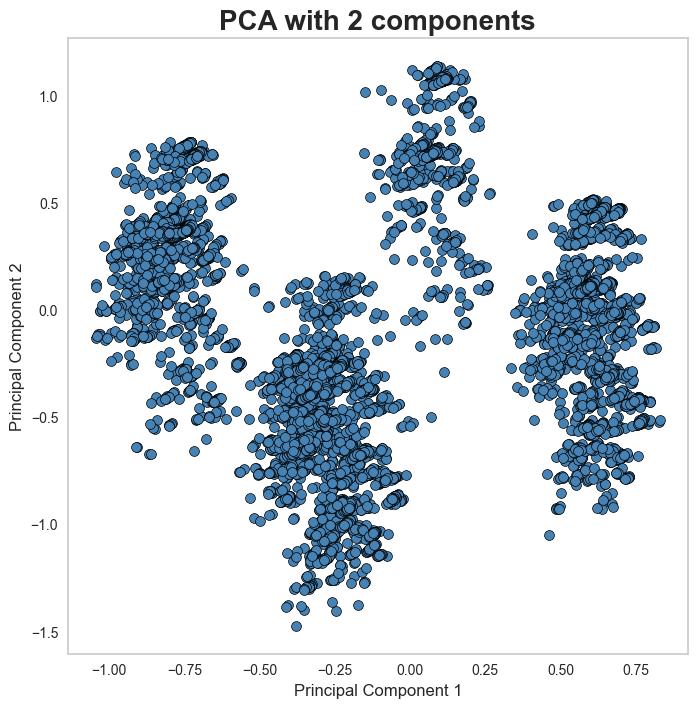

In [48]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 12)
ax.set_ylabel('Principal Component 2', fontsize = 12)
ax.set_title('PCA with 2 components', fontsize = 20, fontweight = 'bold')


ax.scatter(df_pca['principal component 1'], df_pca['principal component 2'], 
           color='#4682B4',
           edgecolor='black',
           linewidth=0.5,
           s=50)

ax.grid()
plt.show()

By selecting only the first two components from the PCA, we can represent our dataset in 2D. As shown in the plot, the results are interpretable, and we can clearly observe the presence of four distinct clusters.

# **2.3 Clustering** 

1. How can you determine the optimal number of clusters for your data? Please use at least two methods and provide their results.
2. Implement the K-means clustering algorithm (not K-means++) through MapReduce. We request that you develop the algorithm from scratch based on what you've learned in class and run the algorithm on your data.
3. Implement the K-means++ algorithm from scratch and apply it to your data. Do you notice any differences between the results obtained using random initialization and those achieved with K-means++? Please explain your observations and discuss why these differences might occur.
4. Ask an LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to recommend another clustering algorithm. Use that LLM to describe the workings of the algorithm, as well as its advantages and disadvantages compared to K-means and K-means++. Additionally, ask to implement the algorithm for you or utilize an existing version from a package. Apply that algorithm to your data and explain any differences you observe in the results compared to those obtained previously.

#### Installing spark and pyngrok

In [3]:
df_pca = pd.read_csv("dataset/df_pca.csv")

In [ ]:
!pip install pyngrok , gdown , pyspark , yellowbrick

ERROR: Invalid requirement: ',': Expected package name at the start of dependency specifier
    ,
    ^


##### Set the spark environment 

In [ ]:
from pyngrok import ngrok
ngrok.set_auth_token("2pWpGICA4f0oP0KnQZRtRGKn8Or_8NVfQvpZtT9G7gZYdPsw")
ngrok_tunnel = ngrok.connect(4050)
print("Spark UI is accessible at:", ngrok_tunnel.public_url)

Spark UI is accessible at: https://240a-95-234-231-188.ngrok-free.app


t=2024-12-07T16:03:21+0100 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=91830e6306de clientid=2b8c0feb93d0c7329816e494e2afeb41
t=2024-12-07T16:03:21+0100 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=1c3783d2c6e5 err="session closed"


In [5]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from libs.analysis_functions import (
    initialize_spark, load_data, preprocess_movies_ratings,
    calculate_avg_ratings_by_genre, calculate_ratings_by_year,
    inspect_data, save_to_csv
)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, split, explode, avg, row_number
from pyspark.sql.window import Window
spark = SparkSession.builder.appName("HW4").config("spark.ui.port", "4050").getOrCreate()

In [6]:
sc = spark.sparkContext

In [7]:
sc.stop()

##### Import necessary libraries to check the optimal number of clusters 

In [8]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

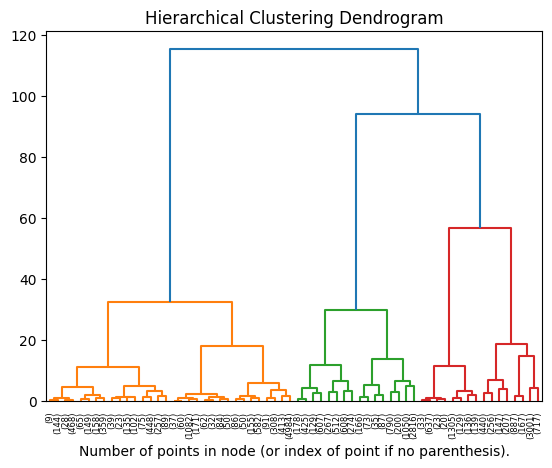

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

    return linkage_matrix


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df_pca)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
linkage_matrix = plot_dendrogram(model, truncate_mode="level", p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### **Choosing the Optimal Number of Clusters**

We first use the k-means algorithm already implemented in the sklearn library to determine the optimal number of clusters. 
We decide to use the Dendrogram, the Elbow Method, Calinski-Harabasz Score and the Silhouette Score to determine the optimal number of clusters.
1. **Hierarchical Clustering Dendrogram**:  
   - **What it does**: This method uses hierarchical clustering to generate a tree-like structure (dendrogram) where data points are merged step-by-step. By visualizing the dendrogram, one can identify the point where the distance between merged clusters increases significantly (a "cut-off" point), indicating the optimal number of clusters. While useful for small datasets, dendrograms can become less interpretable for larger datasets or when dealing with a high number of clusters.  

2. **Distortion Score Elbow Method (for k-means)**:  
   - **What it does**: The distortion score measures the sum of squared distances between data points and their assigned cluster centroids. Plotting the distortion score against the number of clusters, the "elbow" point—where the reduction in distortion begins to plateau—suggests the optimal k. A flatter slope beyond this point indicates diminishing returns from adding more clusters.  

3. **Calinski-Harabasz Score (for k-means)**:  
   - **What it does**: This score evaluates cluster quality by comparing the ratio of between-cluster dispersion to within-cluster dispersion. Higher scores indicate more distinct clusters. A peak or plateau in the Calinski-Harabasz score suggests the optimal number of clusters.  

4. **Silhouette Score (for k-means)**:  
   - **What it does**: The silhouette score measures how well-separated each point is from points in other clusters compared to points in its own cluster. Scores range from -1 to 1, where values close to 1 indicate well-defined clusters, 0 suggests overlapping clusters, and negative values indicate points assigned to the wrong clusters. The silhouette score helps identify k where clusters are both tight and well-separated.  

---

All metrics consistently point to **k = 4** as the optimal number of clusters for your dataset:
- The **Distortion Score Elbow** method identifies a natural balance between compactness and efficiency at **k = 4**.  
- The **Calinski-Harabasz Score** is maximized at **k = 4**, suggesting clear separability between clusters.  
- The **Silhouette Score** is highest at **k = 4**, confirming well-defined and cohesive clusters.  

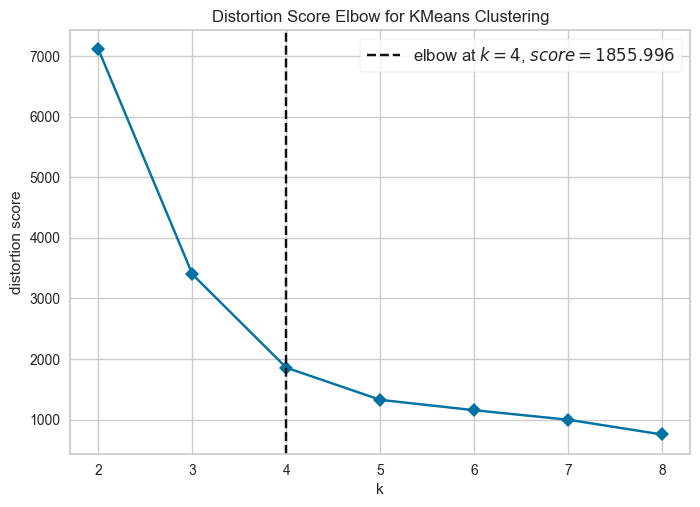

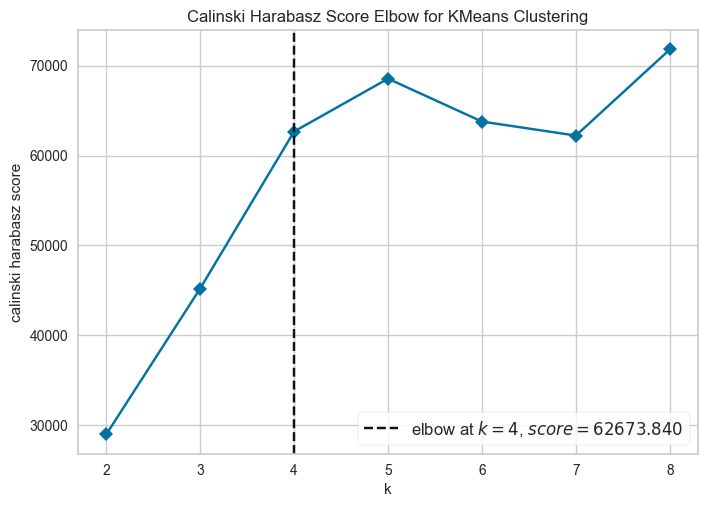

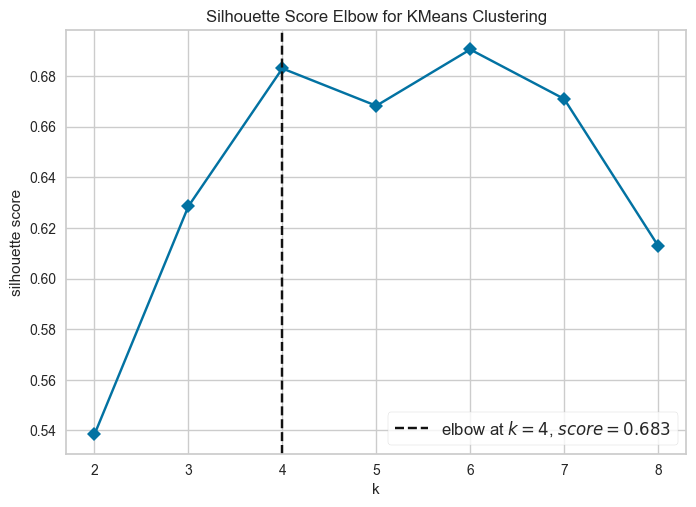

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [11]:
# Set a fixed random seed
seed = 271

# Instantiate the clustering model with a fixed random_state
model = KMeans(random_state=seed)

# Visualize the elbow method using distortion (inertia)
visualizer = KElbowVisualizer(model, k=(2, 9), timings=False)
visualizer.fit(df_pca)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

# Visualize the elbow method using Calinski-Harabasz metric
visualizer = KElbowVisualizer(
    model, k=(2, 9), metric='calinski_harabasz', timings=False
)
visualizer.fit(df_pca)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

# Visualize the elbow method using Silhouette score
visualizer = KElbowVisualizer(
    model, k=(2, 9), metric='silhouette', timings=False
)
visualizer.fit(df_pca)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

#### **Map Reduce**

**MapReduce** is a programming model and a framework designed to process large datasets in a distributed and parallel manner. It was popularized by Google and is widely used in big data frameworks like Apache Hadoop and **Apache Spark**. Its main goal is to enable efficient computation on vast amounts of data spread across multiple machines (nodes) in a cluster.

It's based on the concept of breaking down a problem into smaller, more manageable subproblems, which can then be solved independently and combined to obtain the final solution: 

1. MapReduce divides the dataset into chunks and processes these chunks in parallel, making it highly scalable. Each task works on a subset of the data independently.

2. The data is represented as key-value pairs throughout the process, which makes it flexible for a variety of computations.

3. By dividing tasks across nodes, MapReduce can recover from failures by reassigning tasks to other nodes in the cluster.


It's possible to divide the process in two main phases: the Map phase and the Reduce phase.

##### 1. **Map Phase**:  
   - **Objective**: Transform and structure the data. Each chunk of the input dataset is processed in parallel by "mappers." The mapper function applies logic to each record, producing intermediate key-value pairs.  

##### 2. **Reduce Phase**:  
   - **Objective**: Aggregate and summarize data from the Map phase. The "reducers" take all key-value pairs with the same key and combine them to produce the final output.  


The steps involved in MapReduce are as follows:  
1. **Input Splitting**:  The input data is divided into smaller chunks (splits), each of which is processed independently by a mapper.

2. **Mapping**:  Each mapper processes its chunk and outputs intermediate key-value pairs.

3. **Shuffling and Sorting**: The intermediate data is grouped by key. All values associated with a specific key are sent to the same reducer.

4. **Reducing**: Reducers aggregate the values for each key and produce the final output.

5. **Output**: The results are stored in the desired format or location.


### **K-Means**  
K-Means is a clustering algorithm used to partition a dataset into $k$ clusters based on similarity. It works iteratively following 3 main steps:    
1. **Initializing Centroids**: Randomly selecting $k$ initial centroids ($k$ is given in input).  
2. **Assigning Points**: Assigning each data point to the nearest centroid based on a distance metric (e.g., Euclidean distance).  
3. **Updating Centroids**: Recalculating the centroids as the mean of all points assigned to each cluster.

The algorithm continues iterating until the centroids stabilize or a maximum number of iterations is reached. The final clusters are determined based on the assigned data points.


### **MapReduce in the K-Means Algorithm**

The implementation of **KMeans** leverages MapReduce for clustering as follows:  

1. **Initialization**:  
   - Centroids are initialized by randomly sampling $k$ data points from the dataset.  
   - The dataset is converted into a distributed dataset using **Spark RDDs** (Resilient Distributed Datasets).  

2. **Mapping Step**:  
   Each data point is mapped to its nearest centroid using the Euclidean distance, this produces key-value pairs where the key is the cluster index and the value is the data point.  

3. **Reducing Step**:  
   Data points are grouped by their cluster index (key), and the new centroids are calculated as the mean of points in each cluster, this aggregates data points for each cluster and computes the new centroids efficiently.  

4. **Iteration**:  
   - Steps 2 and 3 are repeated until the centroids converge (i.e., the total shift of centroids falls below a predefined tolerance) or the maximum number of iterations is reached.  
   - The **shift** is calculated as the sum of Euclidean distances between old and new centroids.  

5. **Final Assignment**:  
   After convergence, points are reassigned to their nearest cluster, and the final centroids and clustered data are returned.  



Using MapReduce in KMeans algorithm it can handle large datasets distributed across multiple nodes, parallelizing the updates of the data points and centroids, reducing computational time and memory usage.
Spark's RDD also simplifies operations like grouping and mapping during clustering, enabling more efficient and concise code.

In [13]:
def k_means(data, k, max_iters=100, tol=1e-6, app_name="KMeans Spark", track_history=False):
    """
    Wrapper function for KMeans class to replicate original usage.

    Args:
        data: Input data as Pandas DataFrame or list of lists.
        k: Number of clusters.
        max_iters: Maximum number of iterations.
        tol: Convergence tolerance.
        app_name: Spark application name.
        track_history: If True, track centroid and label history for visualization.

    Returns:
        centroids: Final centroids.
        clustered_data: Data grouped by clusters.
    """
    model = KmeansSpark(k, max_iters, tol, app_name, track_history)
    return model.fit(data)


In [14]:
# Choose 4 as the number of clusters 
k = 4  

# Run K-Means algorithm on the PCA-transformed dataset with 4 clusters
centroids, clustered_data = k_means(df_pca, k)

Iteration 1: total shift = 0.9165
Iteration 2: total shift = 0.0642
Iteration 3: total shift = 0.0107
Iteration 4: total shift = 0.0048
Iteration 5: total shift = 0.0005
Iteration 6: total shift = 0.0002
Iteration 7: total shift = 0.0002
Iteration 8: total shift = 0.0000
Convergence reached after 8 iterations.


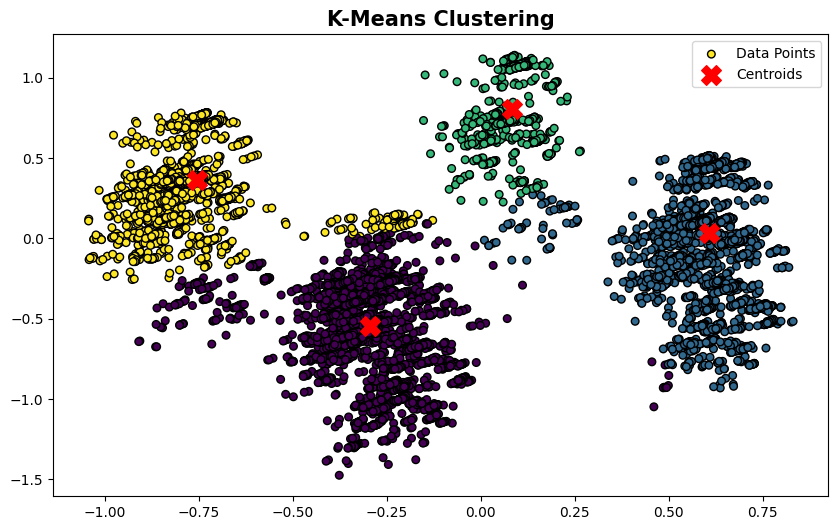

In [15]:
# Convert the centroids and clustered data to NumPy arrays for easier manipulation
points = np.array([point for _, point in clustered_data])
cluster_labels = np.array([label for label, _ in clustered_data])
centroids = np.array(centroids)


# Plot data points and centroids and visualize the clustering result
plt.figure(figsize=(10, 6))
plt.scatter(points[:, 0], points[:, 1], c=cluster_labels, cmap='viridis', s=30,edgecolor='black', label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')
plt.title("K-Means Clustering", fontsize=15, fontweight='bold')
plt.legend()
plt.show()

### **K-Means++**
K-Means++ is an enhanced version of the K-Means algorithm that improves the initialization of cluster centroids. Instead of randomly choosing initial centroids, K-Means++ selects them in a way that ensures centroids are spaced out, reducing the likelihood of poor initialization and in the same time improves convergence speed and reduces the chances of getting stuck in local minima.

The main steps of K-Means++ are as follows:
1. Randomly select the first centroid from the data points.
2. For each remaining centroid:
   - Calculate the squared distance from each data point to its nearest already-chosen centroid.
   - Use these distances to compute a **probability distribution**, where points farther from existing centroids have a higher chance of being selected.
   - Choose the next centroid based on this probability distribution.
 Then repeat the process until the desired number of centroids have been selected.

---

#### **MapReduce in K-Means++**
Also in the K-means++ algorithm we integrates MapReduce for parallelizing key computations, particularly in centroid assignment and update steps:

1. **Initialization of Centroids**:
   - The centroids are initialized locally using the K-Means++ strategy, ensuring a better starting point for the clustering process, avoiding poor random initialization.

2. **Mapping Phase**:
   - Each data point is mapped to its nearest centroid, this step distributes the assignment task across the cluster nodes.

3. **Reducing Phase**:
   - Points assigned to the same cluster are grouped by their cluster index (key) and the new centroid for each cluster is computed as the mean of its assigned points.

4. **Convergence**:
   - The MapReduce steps (mapping assignments and reducing centroids) repeat until the centroid shifts are below the convergence threshold or the maximum number of iterations is reached.


#### **Differences Between K-Means and K-Means++**

1. **Convergence Speed**:
   - K-Means++ typically converges faster than random initialization with less steps and produces more consistent results across runs.
   - With random initialization, the K-Means algorithm may require more iterations to find stable clusters, as initial centroids might be poorly chosen.

2. **Cluster Quality**:
   - The clusters formed with K-Means++ are generally more compact and well-separated, in fact the random initialization of the K-Means can lead to suboptimal clusters.

A good initial separation of centroids in K-Means++ produce better clustering quality than random initialization with K-Means. However, the trade-off is that K-Means++ can be slower and more memory-intensive compared to K-Means.

In [9]:
def kmeans_plus_plus(data, k, max_iterations=100, tolerance=1e-5):
    """

    Args:
        data: Dataset as a NumPy array.
        k: Number of clusters.
        max_iterations: Maximum number of iterations.
        tolerance: Convergence threshold for centroid shift.

    Returns:
        centroids: Final list of centroids.
        cluster_labels: List of cluster assignments for each point.
    """
    model = KMeansPlusPlus(k, max_iterations, tolerance)
    return model.fit(data)

In [10]:
# Dataset with PCA-transformed values
df_pca_values = df_pca.values  # Convert DataFrame to NumPy array

# Number of clusters
k = 4  

# Run K-Means++
centroids_plus, cluster_labels_plus,labels_history_plus, centroids_history_plus = kmeans_plus_plus(df_pca_values, k)

Iteration 1: Total centroid shift = 0.5334
Iteration 2: Total centroid shift = 0.1924
Iteration 3: Total centroid shift = 0.2310
Iteration 4: Total centroid shift = 0.0058
Iteration 5: Total centroid shift = 0.0002
Iteration 6: Total centroid shift = 0.0000
Convergence reached after 6 iterations.


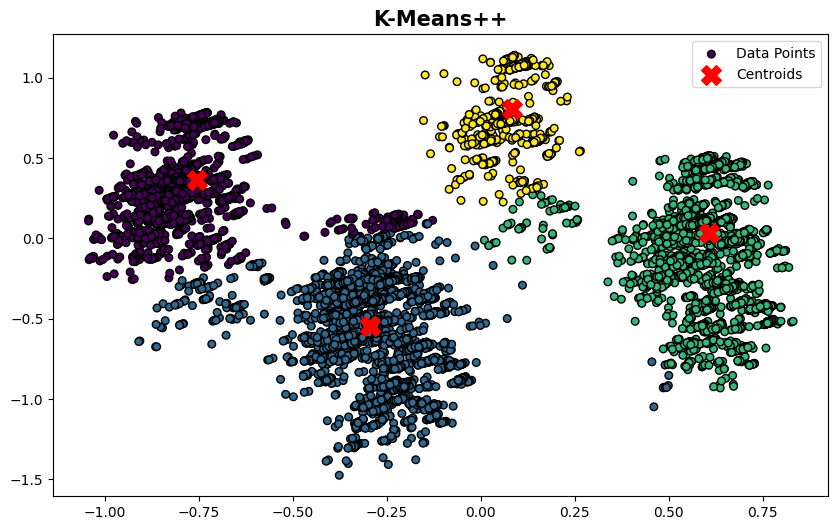

In [11]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(
    df_pca['principal component 1'],
    df_pca['principal component 2'],
    c=cluster_labels_plus,
    cmap='viridis',
    edgecolor='black',
    s=30,
    label='Data Points'
)
plt.scatter(
    centroids_plus[:, 0], centroids_plus[:, 1],
    c='red', s=200, marker='X',
    label='Centroids'
)
plt.title("K-Means++", fontsize=15, fontweight='bold')
plt.legend()
plt.show()

### **Chat GPT algorithm**
---

#### **Recommended Clustering Algorithm: DBSCAN**

#### **How DBSCAN Works**:
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm. It groups points that are close together based on a distance metric and a density threshold. It identifies clusters as regions of high density separated by regions of low density and marks points that don’t belong to any cluster as noise.

Steps:
1. It starts by selecting a random point and checking its neighborhood using a radius (`eps`).
2. If the number of points in the neighborhood is greater than or equal to a minimum threshold (`min_samples`), a cluster is started.
3. Points within the cluster's neighborhood are added recursively if they also meet the density threshold.
4. If a point doesn't meet the density threshold, it's marked as noise (though it might later become part of a cluster).

---

#### **Advantages**:
1. **No need to specify the number of clusters**: Unlike K-means, DBSCAN automatically determines the number of clusters.
2. **Handles noise and outliers**: Points that do not belong to any cluster are labeled as noise.
3. **Works well for arbitrarily shaped clusters**: Can detect clusters of varying shapes and sizes, unlike K-means, which assumes spherical clusters.

---

#### **Disadvantages**:
1. **Parameter sensitivity**: Requires careful tuning of `eps` (neighborhood radius) and `min_samples` (minimum density threshold). Poor choices can lead to under- or over-clustering.
2. **Not ideal for varying densities**: Struggles to handle datasets with clusters of widely differing densities.
3. **Scalability**: Can be computationally expensive for very large datasets, especially in high dimensions.

---

#### **Comparison to K-means/K-means++**:
| Feature                  | K-means/K-means++        | DBSCAN                     |
|--------------------------|--------------------------|----------------------------|
| **Cluster Shape**         | Assumes spherical       | Arbitrarily shaped         |
| **Outliers Handling**     | Merges into clusters    | Marks as noise             |
| **Parameter Sensitivity** | Needs `k` (clusters)    | Needs `eps`, `min_samples` |
| **Performance on Density**| Struggles with varying densities | Handles uniform density well |

---

### **DBSCAN Implementation**

Below is Python code using `scikit-learn` to apply DBSCAN to your data.

Best Parameters: eps=0.07499999999999998, min_samples=7
Best Silhouette Score: 0.5078968941315535


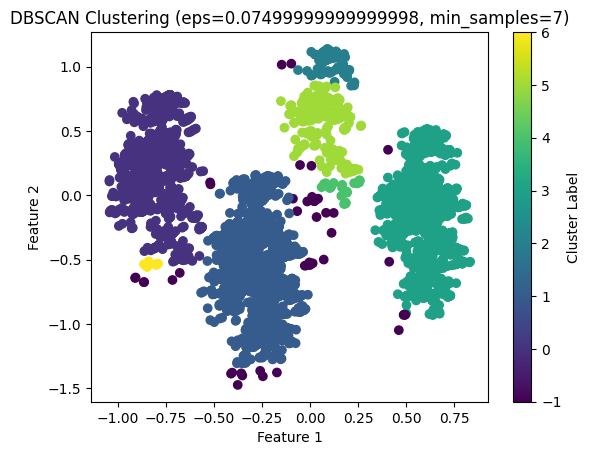

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import itertools
import pandas as pd

# Assuming df_pca is your PCA-reduced DataFrame


# Function to perform grid search for DBSCAN parameters
def grid_search_dbscan(data, eps_values, min_samples_values):
    best_score = -1
    best_params = None
    best_clusters = None

    for eps, min_samples in itertools.product(eps_values, min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(data)

        # Exclude cases where all points are noise or in one cluster
        if len(set(clusters)) > 1:
            score = silhouette_score(data, clusters)
            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)
                best_clusters = clusters

    return best_params, best_score, best_clusters

# Define parameter ranges for grid search
eps_values = np.arange(0.05, 0.1, 0.005)  # Range of epsilon values
min_samples_values = range(7, 9)  # Range of min_samples values

# Perform grid search
best_params, best_score, best_clusters = grid_search_dbscan(df_pca, eps_values, min_samples_values)

# Print the best parameters and corresponding silhouette score
print(f"Best Parameters: eps={best_params[0]}, min_samples={best_params[1]}")
print(f"Best Silhouette Score: {best_score}")

# Visualize the best clustering result
plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=best_clusters, cmap='viridis', marker='o')
plt.title(f"DBSCAN Clustering (eps={best_params[0]}, min_samples={best_params[1]})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label='Cluster Label')
plt.show()




### **Comparison of Results**

#### **Key Observations**:
- DBSCAN may identify outliers as noise (`label = -1`), whereas K-means would merge those points into the nearest cluster.
- Clusters formed by DBSCAN can have irregular shapes, providing better insights for non-spherical data.
- With DBSCAN, you don't need to predefine the number of clusters (`k`), but you must tune `eps` and `min_samples` carefully.
- **Metrics to compare**:
  - Silhouette score: For assessing how well clusters are separated.
  - Visual inspection: Useful for smaller datasets with 2D or 3D visualizations.


 ### 2.4 Best Algorithm
Clustering helps identify natural groupings within data, but no single algorithm works best for every dataset. In this section, you’ll learn how to choose the most suitable clustering method based on your data’s unique characteristics. By analyzing patterns and comparing results, you’ll uncover which algorithm provides the most meaningful insights and clusters.


1. Set the number of clusters to the optimal number $k_{opt}$ based on any of the methods previously.
2. Select three distinct metrics to assess the quality of the clusters. Describe each metric in detail, including the specific aspects they evaluate to determine the effectiveness of the clustering model.
3. Apply the three clustering algorithms used in the prior section to partition the data into $k_{opt}$ clusters. Then, evaluate each model's clustering quality using the selected metrics. Summarize your findings by comparing the results of each algorithm based on the metric evaluations.

#### **Cluster Quality Metrics**
To assess the quality of clusters formed by the algorithms, we use the following three distinct metrics:

1. **Silhouette Score**:
   - **What it evaluates**: Measures how similar a data point is to its own cluster compared to other clusters.
   - **Formula**: For a data point $i$, the silhouette score $S(i)$ is calculated as:
     $$
     S(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
     $$
     Where:
     - $a(i)$: Average intra-cluster distance (mean distance to points in the same cluster).
     - $b(i)$: Average nearest-cluster distance (mean distance to points in the nearest cluster).
   - **Range**: Between -1 and 1. A higher score indicates well-defined and separated clusters.
   - **What it tells us**: If clusters are tight and well-separated from each other.

2. **Calinski-Harabasz Index**:
   - **What it evaluates**: Measures the ratio of the between-cluster dispersion to the within-cluster dispersion.
   - **Formula**:
     $$
     \text{CH Index} = \frac{\text{trace}(B_k)}{\text{trace}(W_k)} \cdot \frac{N - k}{k - 1}
     $$
     Where:
     - $B_k$: Between-cluster dispersion matrix.
     - $W_k$: Within-cluster dispersion matrix.
     - $N$: Number of samples.
     - $k$: Number of clusters.
   - **Range**: Higher values indicate better-defined clusters.
   - **What it tells us**: How compact and distinct the clusters are.

3. **Davies-Bouldin Index**:
   - **What it evaluates**: Measures the average similarity ratio of each cluster with its most similar cluster.
   - **Formula**:
     $$
     \text{DB Index} = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right)
     $$
     Where:
     - $\sigma_i$: Average distance between each point in cluster $i$ and the centroid of $i$.
     - $d(c_i, c_j)$: Distance between the centroids of clusters $i$ and $j$.
   - **Range**: Lower values indicate better clustering.
   - **What it tells us**: Evaluates the compactness and separation of clusters.


In [45]:
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance_ratio}")

Explained Variance Ratio: [0.18568372 0.14465276 0.09548679 0.07910742]


In [18]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd

# Function to evaluate clustering results
def evaluate_clusters(data, labels, algorithm_name):
    """Evaluate clustering quality using three metrics."""
    metrics = {}

    # Silhouette Score (only if more than 1 cluster exists)
    if len(set(labels)) > 1:  # Silhouette cannot be computed for one cluster
        metrics["Silhouette Score"] = silhouette_score(data, labels)
    else:
        metrics["Silhouette Score"] = "N/A"

    # Calinski-Harabasz Index
    if len(set(labels)) > 1:
        metrics["Calinski-Harabasz"] = calinski_harabasz_score(data, labels)
    else:
        metrics["Calinski-Harabasz"] = "N/A"

    # Davies-Bouldin Index
    if len(set(labels)) > 1:
        metrics["Davies-Bouldin"] = davies_bouldin_score(data, labels)
    else:
        metrics["Davies-Bouldin"] = "N/A"

    print(f"\nMetrics for {algorithm_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.3f}" if isinstance(value, float) else f"{metric}: {value}")

    return metrics

# Evaluate DBSCAN
dbscan_metrics = evaluate_clusters(df_pca, best_clusters, "DBSCAN")

# Evaluate K-Means++
kmeans_plus_metrics = evaluate_clusters(df_pca_values, cluster_labels_plus, "K-Means++")

# Evaluate K-Means
kmeans_metrics = evaluate_clusters(df_pca, cluster_labels, "K-Means")

# Summarize Results
summary = {
    "DBSCAN": dbscan_metrics,
    "K-Means++": kmeans_plus_metrics,
    "K-Means": kmeans_metrics
}

summary_df = pd.DataFrame(summary)
print("\nSummary of Results:")
display(summary_df)



Metrics for DBSCAN:
Silhouette Score: 0.508
Calinski-Harabasz: 27082.783
Davies-Bouldin: 1.927

Metrics for K-Means++:
Silhouette Score: 0.683
Calinski-Harabasz: 62673.845
Davies-Bouldin: 0.404

Metrics for K-Means:
Silhouette Score: 0.683
Calinski-Harabasz: 62673.845
Davies-Bouldin: 0.404

Summary of Results:


,DBSCAN,K-Means++,K-Means
Silhouette Score,0.507897,0.683013,0.683013
Calinski-Harabasz,27082.782813,62673.844736,62673.844736
Davies-Bouldin,1.927496,0.403567,0.403567


### **1. DBSCAN Results**
- **Silhouette Score: 0.508**  
  The moderate score suggests that the clusters are reasonably separated, but not as well-defined as K-Means.
  
- **Calinski-Harabasz: 27,050.107**  
  This relatively low score indicates that the clusters are less compact and separated compared to K-Means. 

- **Davies-Bouldin: 1.997**  
  A higher Davies-Bouldin score indicates that the clusters are less compact and have more overlap. This suggests that the clusters identified by DBSCAN are not as tightly grouped.

### **2. K-Means++ and K-Means Results**
- **Silhouette Score: 0.683**  
  A much higher score than DBSCAN, indicating well-separated and well-defined clusters. K-Means++ benefits from its initialization strategy, which helps avoid suboptimal clustering.

- **Calinski-Harabasz: 62,673.844**  
  This high score indicates that the clusters formed are compact and well-separated. K-Means tends to perform well on datasets with convex clusters.

- **Davies-Bouldin: 0.404**  
  A low score reflects very compact and well-separated clusters. This is an ideal result for clustering.



  - **K-Means/K-Means++** outperformed DBSCAN in all metrics. The clusters formed are tighter (lower Davies-Bouldin), better separated (higher Silhouette Score), and more compact (higher Calinski-Harabasz).

- **When to Use DBSCAN**:  
  - If the data contains noise or non-convex clusters, DBSCAN might still be worth exploring. However, the parameters (`eps` and `min_samples`) need to be carefully tuned to achieve competitive results.


## 3. Bonus Question
K-means is an iterative algorithm, meaning that with each iteration, it refines the clusters by adjusting them based on the distance of each data point relative to the center of each cluster. This process continues until it reaches a point of convergence or hits a set limit on the number of iterations. You might want to track the progress of forming your clusters.

1. Select two variables* from your instances to display them on a 2D plot. Then, illustrate the progression of the clusters as they change at each iteration. We expect a plot for each iteration, displaying the instances and the clusters they belong to. Select the two features that most effectively separate visual instances belonging to different clusters. Explain the method you used to determine these features.

__*Note:__ Depending on the variables you want to use for clustering, whether they are the original movie features or the components derived from PCA, you may select two features/components that best help to visually display the clusters.

To visualize the progression of clusters during the K-means algorithm, I chose to use the two principal components obtained through PCA.  
PCA reduces the dimensionality of the data while preserving the most significant variance then these two components capture the majority of the variance in the dataset, making it easier to visualize the clusters in a two-dimensional space.

Instead of creating a plot for each iteration, I created an interactive Plotly plot that shows the movement of centroids at each iteration and how the clusters change as a result. The points are color-coded according to the cluster they belong to, so when a centroid moves and some points change clusters, the change is visually indicated by the shift in color.

I chose to use the two PCA components because they provide a simple, effective way to separate and visualize the clusters in 2D. This would not have been possible with the original high-dimensional features, which are harder to represent visually. By using the components derived from PCA, which capture the most important patterns in the data, I was able to show the clustering process in a clear and interpretable manner.

In [ ]:

def visualize_kmeans_results(data, centroids_history, labels_history):
    """
    Args:
    - data: Dataset originale (array NumPy, 2D)
    - centroids_history: Lista della storia dei centroidi
    - labels_history: Lista della storia delle etichette dei cluster

    Returns:
    - Figura interattiva Plotly
    """
    if data.shape[1] > 2:
        print("Avviso: il dataset ha più di 2 dimensioni. Uso solo le prime 2.")
        data = data[:, :2]
    
    visualizer = KMeansVisualizer(data, centroids_history, labels_history)+
    return visualizer.create_visualization()

## *for this animated output go to the readme in the repo, because is larger than 25 mb so we cant plot here (github repo do not accept file larger than 25 mb !)*

In [ ]:
# Crea visualizzazione
#fig = visualize_kmeans_results(df_pca_values, centroids_history_plus, labels_history_plus)

# Mostra figura
#fig.show()